In [1]:
import mdtraj as md
import pyemma as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Union, Tuple
from pathlib import Path
import pickle
import seaborn as sns
import os
from itertools import product
import string

import matplotlib as mpl
from matplotlib import colors

from msmtools.estimation import transition_matrix as _transition_matrix
from msmtools.analysis import timescales as _timescales

import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral, Ramachandran

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mpl.rcParams['savefig.bbox'] = 'tight'
sns.set_style("white")
sns.set_style({'font.family':'sans-serif', 'font.serif':'Arial'})

In [3]:
def featurizer(hp_dict: Dict, traj_paths: List[str], top_path: str) -> List[np.ndarray]:
    if hp_dict['feature__value'] == 'dihedrals':
        assert hp_dict['dihedrals__which'] == 'all'
        def f(traj: md.Trajectory, **kwargs) -> np.ndarray:
            _, phi = md.compute_phi(traj)
            _, psi = md.compute_psi(traj)
            _, chi1 = md.compute_chi1(traj)
            _, chi2 = md.compute_chi2(traj)
            _, chi3 = md.compute_chi3(traj)
            _, chi4 = md.compute_chi4(traj)
            _, chi5 = md.compute_chi5(traj)
            ftraj = np.concatenate([phi, psi, chi1, chi2, chi3, chi4, chi5], axis=1)
            ftraj = np.concatenate([np.cos(ftraj), np.sin(ftraj)], axis=1)
            return ftraj

    elif hp_dict['feature__value'] == 'distances':
        def f(traj: md.Trajectory, **kwargs):
            scheme = kwargs['distances__scheme']
            transform = kwargs['distances__transform']
            centre = kwargs['distances__centre']
            steepness = kwargs['distances__steepness']
            ftraj, _ = md.compute_contacts(traj, scheme=scheme)
            if transform=='logistic':
                ftraj = 1.0/(1+np.exp(-steepness*(ftraj - centre)))
            return ftraj
    else:
        raise ValueError
    ftrajs = []
    for traj_path in traj_paths:
        traj = md.load(traj_path, top=top_path)
        ftrajs.append(f(traj, **hp_dict))
    return ftrajs


def tica(hp_dict: Dict[str, Union[float, int, str]], ftrajs: List[np.ndarray]) -> List[np.ndarray]:
    lag = hp_dict['tica__lag']
    stride = hp_dict['tica__stride']
    dim = hp_dict['tica__dim']
    tica = pm.coordinates.tica(ftrajs, lag=lag, dim=dim, kinetic_map=True)
    ttrajs = tica.get_output()
    return ttrajs, tica

def kmeans(hp_dict: Dict, ttrajs: List[np.ndarray], seed: int) -> List[np.ndarray]:
    k = hp_dict['cluster__k']
    max_iter = hp_dict['cluster__max_iter']
    stride = hp_dict['cluster__stride']
    kmeans = pm.coordinates.cluster_kmeans(ttrajs, k=k, max_iter=max_iter, stride=stride, fixed_seed=seed, n_jobs=1)
    dtrajs = kmeans.dtrajs
    return dtrajs, kmeans


def its(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    its_obj = pm.msm.timescales_msm(dtrajs=dtrajs, lags=lags, nits=nits)
    return its_obj.timescales


def score(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    all_vs = []
    for lag in lags: 
        m = pm.msm.estimate_markov_model(dtrajs, lag=lag)
        vs = np.array([m.score(dtrajs, score_k=k) for k in range(2, nits+2)])
        vs = vs.reshape(1, -1)
        all_vs.append(vs)
    all_vs = np.concatenate(all_vs, axis=0)
    return all_vs
        


def bootstrap(ftrajs: List[np.ndarray], rng: np.random.Generator) -> List[np.ndarray]:
    probs = np.array([x.shape[0] for x in ftrajs])
    probs = probs/np.sum(probs)
    ix = np.arange(len(ftrajs))
    new_ix = rng.choice(ix,size=len(ftrajs), p=probs, replace=True)
    return [ftrajs[i] for i in new_ix], new_ix



def summarise(df):
    df_summary = df.groupby(['hp_ix', 'lag', 'process']).agg(median=(0, lambda x: np.quantile(x, 0.5)),
                                                                   lb=(0, lambda x: np.quantile(x, 0.025)),
                                                                   ub=(0, lambda x: np.quantile(x, 0.975)), 
                                                                   count =(0, lambda x: x.shape[0]-x.isna().sum()))
    return df_summary


def samples_to_summary(samples: np.ndarray, lags: List[int],  hp_ix: int)-> pd.DataFrame: 
    """
    samples=np.ndarray[lagtime, process, bs_sample]
    """
    df = pd.concat({(hp_ix, lags[i], j+2): pd.DataFrame(samples[i, j, :]) for i in range(samples.shape[0]) for j in range(samples.shape[1])})
    df.index.rename(('hp_ix', 'lag', 'process', 'bs_ix'), inplace=True)
    df_summary = summarise(df)
    return df_summary

In [33]:
# MSM parameters

protein = 'BBA'
seed = 49587
rng = np.random.default_rng(seed)
lags = list(range(1, 102, 10))
n_bootstraps = 100
nits= 25
lag = 41
hp_ix = 227
# hp_ixs = [52, 218]
hp_ixs = [24, 95, 227]
n_ts = 10

# PCCA+ parameters
n_sets = 3
core_membership_cutoff = 0.95

# Input path 
summary_path = r'../BBA/t2.h5'
    #r'../CLN/maximize_t2.h5'
top_path = '../../../1fme/protein.pdb'
    #'../../../chignolin/protein.pdb'
traj_paths = list(Path(r'../../../1fme').rglob(f'1FME-*.xtc'))
    # list(Path(r'../../../chignolin').rglob(f'CLN025-0-protein-*.xtc'))
traj_paths = [str(x) for x in traj_paths]
traj_paths.sort()

In [34]:
hps = pd.read_hdf(summary_path)

# Rename hyperparameters
hps.rename(columns=dict(number='hp_ix', 
                        params_centre='distances__centre', 
                        params_feature='feature__value', 
                        params_n_clusters='cluster__k', 
                        params_scheme='distances__scheme', 
                        params_steepness='distances__steepness', 
                        params_tica_dim='tica__dim', 
                        params_tica_lag='tica__lag', 
                        params_transform='distances__transform'), inplace=True)
hps['tica__stride'] = 1
hps['cluster__stride'] = 1
hps['dihedrals__which'] = 'all'
hps['cluster__max_iter'] = 1000
hps['feature'] = hps.apply(lambda x: f"{x['feature__value']}" if x['feature__value'] =='dihedrals' else f"{x['distances__transform']}-{x['feature__value']}", axis=1)

# Rename features
def f(x):
    for short, long in short_names.items(): 
        x = x.replace(short, long)
    return x
short_names = {'dihedrals': 'dihed.','logistic-distances': 'logit(dist.)', 'linear-distances': 
              'dist.'}
hps['feature'] = hps['feature'].apply(f)

hps.query(f'hp_ix=={hp_ix}')

,hp_ix,value,datetime_start,datetime_complete,duration,distances__centre,feature__value,cluster__k,distances__scheme,distances__steepness,tica__dim,tica__lag,distances__transform,state,tica__stride,cluster__stride,dihedrals__which,cluster__max_iter,feature
227,227,46614.162448,2023-03-07 23:29:44.167550,2023-03-07 23:34:11.801723,0 days 00:04:27.634173,0.770562,distances,444,ca,3.288995,20,53,logistic,COMPLETE,1,1,all,1000,logit(dist.)


---
### Compute BS MSM --- Figure 2

In [9]:
# Output path 
hps.set_index(['hp_ix'], inplace=True)
base_dir = Path(f"{protein}/hp{hp_ix}_{hps.loc[hp_ix,:]['feature']}")
fig_dir = Path.joinpath(base_dir, Path(f"figures"))
fig_dir.mkdir(parents=True, exist_ok=True)

In [10]:
ftrajs_all = featurizer(hps.loc[hp_ix,:].to_dict(), traj_paths, top_path)

# Bootstrap results to get timescales and gaps
ts_samples = []
gap_samples = []

for i in range(n_bootstraps):
    #ftrajs = ftrajs_all
    ftrajs, ftrajs_ix = bootstrap(ftrajs_all, rng)
    assert len(ftrajs) == len(ftrajs_all)
    
    ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
    dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)
    
    if n_bootstraps>1:
        out_dir = Path.joinpath(base_dir, Path(f'bs_{i}'))
    else:
        out_dir = Path.joinpath(base_dir, Path(f'dtrajs'))
        
    out_dir.mkdir(parents=True, exist_ok=True)
    
    for j in range(len(traj_paths)): 
        traj_path = Path(traj_paths[j]).resolve()
        np.save(file=out_dir.joinpath(traj_path.with_suffix('.npy').name), arr=dtrajs[j])
        
    msm = pm.msm.estimate_markov_model(dtrajs, lag=lag)
    ts = msm.timescales(n_ts)
    
    ts_samples.append(ts[:-1]/1000)
    gap_samples.append(ts[:-1]/ts[1:])
    
ts_samples = np.array(ts_samples)
gap_samples = np.array(gap_samples)

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████████| 164/164 [00:00<00:00, 491.76it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/103 [00:00<?, ?
initialize kmeans++ centers:  94%|▉| 97/103 [00:01<00:
kmeans iterations:   0%| | 1/1000 [00:01<22:23,  1.34s
kmeans iterations:   0%| | 2/1000 [00:01<11:27,  1.45i
kmeans iterations:   0%| | 3/1000 [00:01<07:48,  2.13i

kmeans iterations:   1%| | 13/1000 [00:04<03:54,  4.20
kmeans iterations:   1%| | 14/1000 [00:04<03:54,  4.21
kmeans iterations:   2%| | 15/1000 [00:04<03:55,  4.19
kmeans iterations:   2%| | 16/1000 [00:04<03:48,  4.30
kmeans iterations:   2%| | 17/1000 [00:05<03:50,  4.27
kmeans iterations:   2%| | 18/1000 [00:05<03:44,  4.38
kmeans iterations:   2%| | 19/1000 [00:05<03:45,  4.35
kmeans iterations:   2%| | 20/1000 [00:05<03:40,  4.44
kmeans iterations:   2%| | 21/1000 [00:05<03:37,  4.51
kmeans iterations:   2%| | 22/1000 [00:06<03:39,  4.46
kmeans iterations:   2%| | 23/1000 [00:06<03:43,  4.37
kmeans iterations:   2%| | 24/1000 [00:06<03:39,  4.45
kmeans iterations:   2%| | 25/1000 [00:06<03:36,  4.51
kmeans iterations:   3%| | 26/1000 [00:06<03:34,  4.55
kmeans iterations:   3%| | 27/1000 [00:07<03:39,  4.42
kmeans iterations:   3%| | 28/1000 [00:07<03:42,  4.36
kmeans iterations:   3%| | 29/1000 [00:07<03:43,  4.34
kmeans iterations:   3%| | 30/1000 [00:07<03:39,  4.42
kmeans ite

kmeans iterations:   7%| | 72/1000 [00:17<03:32,  4.37
kmeans iterations:   7%| | 73/1000 [00:17<03:28,  4.44
kmeans iterations:   7%| | 74/1000 [00:17<03:30,  4.39
kmeans iterations:   8%| | 75/1000 [00:18<03:27,  4.46
kmeans iterations:   8%| | 76/1000 [00:18<03:30,  4.39
kmeans iterations:   8%| | 77/1000 [00:18<03:26,  4.46
kmeans iterations:   8%| | 78/1000 [00:18<03:25,  4.49
kmeans iterations:   8%| | 79/1000 [00:19<03:33,  4.32
kmeans iterations:   8%| | 80/1000 [00:19<03:32,  4.32
kmeans iterations:   8%| | 81/1000 [00:19<03:31,  4.34
kmeans iterations:   8%| | 82/1000 [00:19<03:28,  4.41
kmeans iterations:   8%| | 83/1000 [00:19<03:25,  4.46
kmeans iterations:   8%| | 84/1000 [00:20<03:28,  4.38
kmeans iterations:   8%| | 85/1000 [00:20<03:28,  4.39
kmeans iterations:   9%| | 86/1000 [00:20<03:32,  4.30
kmeans iterations:   9%| | 87/1000 [00:20<03:28,  4.37
kmeans iterations:   9%| | 88/1000 [00:21<03:35,  4.23
kmeans iterations:   9%| | 89/1000 [00:21<03:30,  4.34
kmeans ite

kmeans iterations:   2%| | 21/1000 [00:05<03:38,  4.49
kmeans iterations:   2%| | 22/1000 [00:05<03:36,  4.53
kmeans iterations:   2%| | 23/1000 [00:06<03:34,  4.55
kmeans iterations:   2%| | 24/1000 [00:06<03:42,  4.39
kmeans iterations:   2%| | 25/1000 [00:06<03:43,  4.35
kmeans iterations:   3%| | 26/1000 [00:06<03:45,  4.32
kmeans iterations:   3%| | 27/1000 [00:07<03:45,  4.31
kmeans iterations:   3%| | 28/1000 [00:07<03:40,  4.40
kmeans iterations:   3%| | 29/1000 [00:07<03:37,  4.47
kmeans iterations:   3%| | 30/1000 [00:07<03:39,  4.42
kmeans iterations:   3%| | 31/1000 [00:07<03:35,  4.49
kmeans iterations:   3%| | 32/1000 [00:08<03:33,  4.54
kmeans iterations:   3%| | 33/1000 [00:08<03:31,  4.57
kmeans iterations:   3%| | 34/1000 [00:08<03:30,  4.60
kmeans iterations:   4%| | 35/1000 [00:08<03:28,  4.62
kmeans iterations:   4%| | 36/1000 [00:09<03:27,  4.65
kmeans iterations:   4%| | 37/1000 [00:09<03:27,  4.65
kmeans iterations:   4%| | 38/1000 [00:09<03:26,  4.67
kmeans ite

kmeans iterations:   5%| | 51/1000 [00:12<03:28,  4.54
kmeans iterations:   5%| | 52/1000 [00:12<03:33,  4.44
kmeans iterations:   5%| | 53/1000 [00:13<03:32,  4.46
initialize kmeans++ centers: 100%|█| 103/103 [00:13<00
kmeans iterations:   6%| | 55/1000 [00:13<03:37,  4.35
kmeans iterations:   6%| | 56/1000 [00:13<03:32,  4.44
kmeans iterations:   6%| | 57/1000 [00:14<03:39,  4.29
kmeans iterations:   6%| | 58/1000 [00:14<03:41,  4.24
kmeans iterations:   6%| | 59/1000 [00:14<03:45,  4.17
kmeans iterations:   6%| | 60/1000 [00:14<03:50,  4.08
kmeans iterations:   6%| | 61/1000 [00:15<03:49,  4.10
kmeans iterations:   6%| | 62/1000 [00:15<03:41,  4.23
kmeans iterations:   6%| | 63/1000 [00:15<03:43,  4.20
kmeans iterations:   6%| | 64/1000 [00:15<03:37,  4.30
kmeans iterations:   6%| | 65/1000 [00:16<03:33,  4.38
kmeans iterations:   7%| | 66/1000 [00:16<03:37,  4.29
kmeans iterations:   7%| | 67/1000 [00:16<03:38,  4.27
kmeans iterations:   7%| | 68/1000 [00:16<03:33,  4.36
kmeans ite

kmeans iterations:   1%| | 12/1000 [00:03<03:42,  4.44
kmeans iterations:   1%| | 13/1000 [00:04<03:46,  4.35
kmeans iterations:   1%| | 14/1000 [00:04<03:51,  4.25
kmeans iterations:   2%| | 15/1000 [00:04<03:46,  4.34
kmeans iterations:   2%| | 16/1000 [00:04<03:42,  4.43
kmeans iterations:   2%| | 17/1000 [00:04<03:38,  4.49
kmeans iterations:   2%| | 18/1000 [00:05<03:36,  4.53
kmeans iterations:   2%| | 19/1000 [00:05<03:35,  4.55
kmeans iterations:   2%| | 20/1000 [00:05<03:34,  4.57
kmeans iterations:   2%| | 21/1000 [00:05<03:34,  4.57
kmeans iterations:   2%| | 22/1000 [00:05<03:34,  4.56
kmeans iterations:   2%| | 23/1000 [00:06<03:33,  4.57
kmeans iterations:   2%| | 24/1000 [00:06<03:45,  4.33
kmeans iterations:   2%| | 25/1000 [00:06<03:40,  4.41
kmeans iterations:   3%| | 26/1000 [00:06<03:36,  4.49
kmeans iterations:   3%| | 27/1000 [00:07<03:34,  4.53
kmeans iterations:   3%| | 28/1000 [00:07<03:33,  4.55
kmeans iterations:   3%| | 29/1000 [00:07<03:43,  4.35
kmeans ite

kmeans iterations:   7%| | 70/1000 [00:17<03:30,  4.42
kmeans iterations:   7%| | 71/1000 [00:17<03:33,  4.36
kmeans iterations:   7%| | 72/1000 [00:17<03:30,  4.41
kmeans iterations:   7%| | 73/1000 [00:17<03:28,  4.44
kmeans iterations:   7%| | 74/1000 [00:17<03:26,  4.49
kmeans iterations:   8%| | 75/1000 [00:18<03:30,  4.39
kmeans iterations:   8%| | 76/1000 [00:18<03:36,  4.28
kmeans iterations:   8%| | 77/1000 [00:18<03:30,  4.38
kmeans iterations:   8%| | 78/1000 [00:18<03:38,  4.23
kmeans iterations:   8%| | 79/1000 [00:19<03:34,  4.29
kmeans iterations:   8%| | 80/1000 [00:19<03:41,  4.16
kmeans iterations:   8%| | 81/1000 [00:19<03:34,  4.29
kmeans iterations:   8%| | 82/1000 [00:19<03:30,  4.37
kmeans iterations:   8%| | 83/1000 [00:20<03:26,  4.43
kmeans iterations:   8%| | 84/1000 [00:20<03:24,  4.47
kmeans iterations:   8%| | 85/1000 [00:20<03:23,  4.50
kmeans iterations:   9%| | 86/1000 [00:20<03:27,  4.40
kmeans iterations:   9%| | 87/1000 [00:20<03:31,  4.31
kmeans ite

kmeans iterations:   8%| | 83/1000 [00:19<03:23,  4.50
kmeans iterations:   8%| | 84/1000 [00:20<03:23,  4.50
kmeans iterations:   8%| | 85/1000 [00:20<03:25,  4.44
kmeans iterations:   9%| | 86/1000 [00:20<03:24,  4.46
kmeans iterations:   9%| | 87/1000 [00:20<03:22,  4.50
kmeans iterations:   9%| | 88/1000 [00:20<03:22,  4.50
kmeans iterations:   9%| | 89/1000 [00:21<03:21,  4.52
kmeans iterations:   9%| | 90/1000 [00:21<03:21,  4.52
kmeans iterations:   9%| | 91/1000 [00:21<03:24,  4.44
kmeans iterations:   9%| | 92/1000 [00:21<03:23,  4.47
kmeans iterations:   9%| | 93/1000 [00:22<03:21,  4.50
kmeans iterations:   9%| | 94/1000 [00:22<03:25,  4.40
kmeans iterations:  10%| | 95/1000 [00:22<03:33,  4.24
100%|███████████████| 103/103 [00:23<00:00,  4.47it/s]

100%|█████████████| 164/164 [00:00<00:00, 2073.32it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/minico

kmeans iterations:   2%| | 15/1000 [00:04<03:40,  4.47
kmeans iterations:   2%| | 16/1000 [00:04<03:40,  4.47
kmeans iterations:   2%| | 17/1000 [00:04<03:38,  4.50
kmeans iterations:   2%| | 18/1000 [00:05<03:38,  4.49
kmeans iterations:   2%| | 19/1000 [00:05<03:38,  4.49
kmeans iterations:   2%| | 20/1000 [00:05<03:44,  4.37
kmeans iterations:   2%| | 21/1000 [00:05<03:40,  4.44
kmeans iterations:   2%| | 22/1000 [00:06<03:43,  4.38
kmeans iterations:   2%| | 23/1000 [00:06<03:38,  4.47
kmeans iterations:   2%| | 24/1000 [00:06<03:36,  4.52
kmeans iterations:   2%| | 25/1000 [00:06<03:33,  4.56
kmeans iterations:   3%| | 26/1000 [00:06<03:33,  4.56
kmeans iterations:   3%| | 27/1000 [00:07<03:42,  4.37
kmeans iterations:   3%| | 28/1000 [00:07<03:39,  4.43
kmeans iterations:   3%| | 29/1000 [00:07<03:36,  4.48
kmeans iterations:   3%| | 30/1000 [00:07<03:35,  4.50
kmeans iterations:   3%| | 31/1000 [00:08<03:33,  4.54
kmeans iterations:   3%| | 32/1000 [00:08<03:33,  4.54
kmeans ite

kmeans iterations:   2%| | 25/1000 [00:06<03:41,  4.41
kmeans iterations:   3%| | 26/1000 [00:07<03:37,  4.48
kmeans iterations:   3%| | 27/1000 [00:07<03:35,  4.51
kmeans iterations:   3%| | 28/1000 [00:07<03:34,  4.53
kmeans iterations:   3%| | 29/1000 [00:07<03:33,  4.55
kmeans iterations:   3%| | 30/1000 [00:07<03:33,  4.55
kmeans iterations:   3%| | 31/1000 [00:08<03:32,  4.56
kmeans iterations:   3%| | 32/1000 [00:08<03:36,  4.47
kmeans iterations:   3%| | 33/1000 [00:08<03:35,  4.50
kmeans iterations:   3%| | 34/1000 [00:08<03:33,  4.52
kmeans iterations:   4%| | 35/1000 [00:09<03:39,  4.40
kmeans iterations:   4%| | 36/1000 [00:09<03:35,  4.46
kmeans iterations:   4%| | 37/1000 [00:09<03:33,  4.50
kmeans iterations:   4%| | 38/1000 [00:09<03:37,  4.42
kmeans iterations:   4%| | 39/1000 [00:09<03:45,  4.26
kmeans iterations:   4%| | 40/1000 [00:10<03:51,  4.15
kmeans iterations:   4%| | 41/1000 [00:10<03:52,  4.12
kmeans iterations:   4%| | 42/1000 [00:10<03:45,  4.25
kmeans ite

initialize kmeans++ centers: 100%|█| 103/103 [00:13<00
kmeans iterations:   5%| | 53/1000 [00:13<03:26,  4.58
kmeans iterations:   5%| | 54/1000 [00:13<03:26,  4.59
kmeans iterations:   6%| | 55/1000 [00:13<03:30,  4.49
kmeans iterations:   6%| | 56/1000 [00:13<03:34,  4.41
kmeans iterations:   6%| | 57/1000 [00:14<03:32,  4.45
kmeans iterations:   6%| | 58/1000 [00:14<03:36,  4.35
kmeans iterations:   6%| | 59/1000 [00:14<03:32,  4.42
kmeans iterations:   6%| | 60/1000 [00:14<03:29,  4.49
kmeans iterations:   6%| | 61/1000 [00:14<03:27,  4.53
kmeans iterations:   6%| | 62/1000 [00:15<03:29,  4.47
kmeans iterations:   6%| | 63/1000 [00:15<03:27,  4.52
kmeans iterations:   6%| | 64/1000 [00:15<03:25,  4.56
kmeans iterations:   6%| | 65/1000 [00:15<03:24,  4.58
kmeans iterations:   7%| | 66/1000 [00:16<03:23,  4.59
kmeans iterations:   7%| | 67/1000 [00:16<03:29,  4.45
kmeans iterations:   7%| | 68/1000 [00:16<03:27,  4.50
kmeans iterations:   7%| | 69/1000 [00:16<03:30,  4.42
kmeans ite

kmeans iterations:   8%| | 80/1000 [00:19<03:22,  4.54
kmeans iterations:   8%| | 81/1000 [00:19<03:21,  4.57
kmeans iterations:   8%| | 82/1000 [00:19<03:32,  4.32
kmeans iterations:   8%| | 83/1000 [00:19<03:28,  4.40
kmeans iterations:   8%| | 84/1000 [00:20<03:32,  4.32
kmeans iterations:   8%| | 85/1000 [00:20<03:33,  4.29
kmeans iterations:   9%| | 86/1000 [00:20<03:30,  4.35
kmeans iterations:   9%| | 87/1000 [00:20<03:32,  4.30
kmeans iterations:   9%| | 88/1000 [00:21<03:27,  4.39
kmeans iterations:   9%| | 89/1000 [00:21<03:30,  4.33
kmeans iterations:   9%| | 90/1000 [00:21<03:27,  4.38
kmeans iterations:   9%| | 91/1000 [00:21<03:24,  4.44
100%|███████████████| 103/103 [00:22<00:00,  4.65it/s]

100%|█████████████| 164/164 [00:00<00:00, 3479.57it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorato

kmeans iterations:   4%| | 40/1000 [00:09<03:28,  4.61
kmeans iterations:   4%| | 41/1000 [00:10<03:39,  4.37
kmeans iterations:   4%| | 42/1000 [00:10<03:35,  4.44
kmeans iterations:   4%| | 43/1000 [00:10<03:43,  4.28
kmeans iterations:   4%| | 44/1000 [00:10<03:47,  4.20
kmeans iterations:   4%| | 45/1000 [00:11<03:42,  4.30
kmeans iterations:   5%| | 46/1000 [00:11<03:41,  4.30
kmeans iterations:   5%| | 47/1000 [00:11<03:43,  4.27
kmeans iterations:   5%| | 48/1000 [00:11<03:37,  4.38
kmeans iterations:   5%| | 49/1000 [00:12<03:33,  4.46
kmeans iterations:   5%| | 50/1000 [00:12<03:30,  4.51
kmeans iterations:   5%| | 51/1000 [00:12<03:28,  4.55
kmeans iterations:   5%| | 52/1000 [00:12<03:27,  4.58
kmeans iterations:   5%| | 53/1000 [00:12<03:25,  4.60
kmeans iterations:   5%| | 54/1000 [00:13<03:26,  4.59
kmeans iterations:   6%| | 55/1000 [00:13<03:25,  4.60
kmeans iterations:   6%| | 56/1000 [00:13<03:25,  4.60
kmeans iterations:   6%| | 57/1000 [00:13<03:24,  4.60
kmeans ite

initialize kmeans++ centers:   0%| | 0/103 [00:00<?, ?
initialize kmeans++ centers:  94%|▉| 97/103 [00:01<00:
kmeans iterations:   0%| | 1/1000 [00:01<22:29,  1.35s
kmeans iterations:   0%| | 2/1000 [00:01<11:22,  1.46i
kmeans iterations:   0%| | 3/1000 [00:01<07:49,  2.12i
kmeans iterations:   0%| | 4/1000 [00:02<06:09,  2.70i
kmeans iterations:   0%| | 5/1000 [00:02<05:13,  3.17i
kmeans iterations:   1%| | 6/1000 [00:02<04:45,  3.48i
kmeans iterations:   1%| | 7/1000 [00:02<04:33,  3.64i
kmeans iterations:   1%| | 8/1000 [00:02<04:24,  3.75i
kmeans iterations:   1%| | 9/1000 [00:03<04:18,  3.83i
kmeans iterations:   1%| | 10/1000 [00:03<04:04,  4.04
kmeans iterations:   1%| | 11/1000 [00:03<03:54,  4.22
kmeans iterations:   1%| | 12/1000 [00:03<03:47,  4.35
kmeans iterations:   1%| | 13/1000 [00:04<03:44,  4.41
kmeans iterations:   1%| | 14/1000 [00:04<03:40,  4.47
kmeans iterations:   2%| | 15/1000 [00:04<03:38,  4.52
kmeans iterations:   2%| | 16/1000 [00:04<03:36,  4.54
kmeans ite

kmeans iterations:  14%|▏| 140/1000 [00:32<03:15,  4.4
kmeans iterations:  14%|▏| 141/1000 [00:32<03:12,  4.4
100%|███████████████| 103/103 [00:33<00:00,  3.11it/s]

100%|█████████████| 164/164 [00:00<00:00, 2127.58it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████████| 164/164 [00:00<00:00, 541.90it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/103 [00:00<?, 

kmeans iterations:   1%| | 14/1000 [00:04<03:37,  4.54
kmeans iterations:   2%| | 15/1000 [00:04<03:35,  4.56
kmeans iterations:   2%| | 16/1000 [00:04<03:41,  4.43
kmeans iterations:   2%| | 17/1000 [00:04<03:38,  4.50
kmeans iterations:   2%| | 18/1000 [00:05<03:36,  4.53
kmeans iterations:   2%| | 19/1000 [00:05<03:35,  4.55
kmeans iterations:   2%| | 20/1000 [00:05<03:34,  4.57
kmeans iterations:   2%| | 21/1000 [00:05<03:43,  4.38
kmeans iterations:   2%| | 22/1000 [00:05<03:39,  4.46
kmeans iterations:   2%| | 23/1000 [00:06<03:41,  4.41
kmeans iterations:   2%| | 24/1000 [00:06<03:38,  4.48
kmeans iterations:   2%| | 25/1000 [00:06<03:34,  4.54
kmeans iterations:   3%| | 26/1000 [00:06<03:33,  4.57
kmeans iterations:   3%| | 27/1000 [00:07<03:31,  4.60
kmeans iterations:   3%| | 28/1000 [00:07<03:31,  4.61
kmeans iterations:   3%| | 29/1000 [00:07<03:29,  4.63
kmeans iterations:   3%| | 30/1000 [00:07<03:29,  4.64
kmeans iterations:   3%| | 31/1000 [00:07<03:28,  4.65
kmeans ite

kmeans iterations:   5%| | 49/1000 [00:12<03:26,  4.60
kmeans iterations:   5%| | 50/1000 [00:12<03:26,  4.59
kmeans iterations:   5%| | 51/1000 [00:12<03:26,  4.59
kmeans iterations:   5%| | 52/1000 [00:12<03:25,  4.61
kmeans iterations:   5%| | 53/1000 [00:12<03:31,  4.48
kmeans iterations:   5%| | 54/1000 [00:13<03:29,  4.52
kmeans iterations:   6%| | 55/1000 [00:13<03:28,  4.54
kmeans iterations:   6%| | 56/1000 [00:13<03:26,  4.57
kmeans iterations:   6%| | 57/1000 [00:13<03:34,  4.41
kmeans iterations:   6%| | 58/1000 [00:14<03:30,  4.47
kmeans iterations:   6%| | 59/1000 [00:14<03:28,  4.50
kmeans iterations:   6%| | 60/1000 [00:14<03:33,  4.40
kmeans iterations:   6%| | 61/1000 [00:14<03:32,  4.43
kmeans iterations:   6%| | 62/1000 [00:14<03:29,  4.49
kmeans iterations:   6%| | 63/1000 [00:15<03:27,  4.51
kmeans iterations:   6%| | 64/1000 [00:15<03:26,  4.53
kmeans iterations:   6%| | 65/1000 [00:15<03:25,  4.54
kmeans iterations:   7%| | 66/1000 [00:15<03:25,  4.54
kmeans ite

kmeans iterations:   7%| | 69/1000 [00:16<03:26,  4.51
kmeans iterations:   7%| | 70/1000 [00:16<03:25,  4.53
kmeans iterations:   7%| | 71/1000 [00:17<03:24,  4.53
kmeans iterations:   7%| | 72/1000 [00:17<03:29,  4.43
kmeans iterations:   7%| | 73/1000 [00:17<03:27,  4.47
kmeans iterations:   7%| | 74/1000 [00:17<03:30,  4.39
kmeans iterations:   8%| | 75/1000 [00:17<03:28,  4.45
kmeans iterations:   8%| | 76/1000 [00:18<03:30,  4.40
kmeans iterations:   8%| | 77/1000 [00:18<03:26,  4.47
kmeans iterations:   8%| | 78/1000 [00:18<03:24,  4.52
kmeans iterations:   8%| | 79/1000 [00:18<03:22,  4.54
kmeans iterations:   8%| | 80/1000 [00:19<03:21,  4.56
kmeans iterations:   8%| | 81/1000 [00:19<03:20,  4.58
kmeans iterations:   8%| | 82/1000 [00:19<03:20,  4.59
100%|███████████████| 103/103 [00:20<00:00,  5.15it/s]

100%|█████████████| 164/164 [00:00<00:00, 3105.35it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to de

kmeans iterations:   2%| | 22/1000 [00:06<03:33,  4.57
kmeans iterations:   2%| | 23/1000 [00:06<03:32,  4.60
kmeans iterations:   2%| | 24/1000 [00:06<03:37,  4.48
kmeans iterations:   2%| | 25/1000 [00:06<03:35,  4.52
kmeans iterations:   3%| | 26/1000 [00:07<03:34,  4.54
kmeans iterations:   3%| | 27/1000 [00:07<03:40,  4.41
kmeans iterations:   3%| | 28/1000 [00:07<03:45,  4.31
kmeans iterations:   3%| | 29/1000 [00:07<03:41,  4.38
kmeans iterations:   3%| | 30/1000 [00:07<03:37,  4.45
kmeans iterations:   3%| | 31/1000 [00:08<03:35,  4.50
kmeans iterations:   3%| | 32/1000 [00:08<03:32,  4.55
kmeans iterations:   3%| | 33/1000 [00:08<03:31,  4.56
kmeans iterations:   3%| | 34/1000 [00:08<03:30,  4.58
kmeans iterations:   4%| | 35/1000 [00:09<03:30,  4.59
kmeans iterations:   4%| | 36/1000 [00:09<03:28,  4.62
kmeans iterations:   4%| | 37/1000 [00:09<03:36,  4.46
kmeans iterations:   4%| | 38/1000 [00:09<03:33,  4.50
kmeans iterations:   4%| | 39/1000 [00:09<03:31,  4.53
kmeans ite

kmeans iterations:   5%| | 53/1000 [00:13<03:30,  4.50
kmeans iterations:   5%| | 54/1000 [00:13<03:28,  4.53
kmeans iterations:   6%| | 55/1000 [00:13<03:27,  4.56
kmeans iterations:   6%| | 56/1000 [00:13<03:26,  4.58
kmeans iterations:   6%| | 57/1000 [00:13<03:29,  4.51
kmeans iterations:   6%| | 58/1000 [00:14<03:27,  4.54
100%|███████████████| 103/103 [00:14<00:00,  7.09it/s]

100%|█████████████| 164/164 [00:00<00:00, 3518.64it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████████| 164/164 [00:00<00:00, 478.15it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/

kmeans iterations:   1%| | 14/1000 [00:04<03:46,  4.36
kmeans iterations:   2%| | 15/1000 [00:04<03:41,  4.44
kmeans iterations:   2%| | 16/1000 [00:04<03:43,  4.40
kmeans iterations:   2%| | 17/1000 [00:05<03:45,  4.37
kmeans iterations:   2%| | 18/1000 [00:05<03:40,  4.46
kmeans iterations:   2%| | 19/1000 [00:05<03:42,  4.41
kmeans iterations:   2%| | 20/1000 [00:05<03:38,  4.49
kmeans iterations:   2%| | 21/1000 [00:05<03:34,  4.55
kmeans iterations:   2%| | 22/1000 [00:06<03:33,  4.58
kmeans iterations:   2%| | 23/1000 [00:06<03:32,  4.60
kmeans iterations:   2%| | 24/1000 [00:06<03:31,  4.62
kmeans iterations:   2%| | 25/1000 [00:06<03:30,  4.63
kmeans iterations:   3%| | 26/1000 [00:07<03:35,  4.53
kmeans iterations:   3%| | 27/1000 [00:07<03:32,  4.58
kmeans iterations:   3%| | 28/1000 [00:07<03:30,  4.61
kmeans iterations:   3%| | 29/1000 [00:07<03:35,  4.51
kmeans iterations:   3%| | 30/1000 [00:07<03:32,  4.56
kmeans iterations:   3%| | 31/1000 [00:08<03:31,  4.59
kmeans ite

kmeans iterations:   4%| | 41/1000 [00:10<03:33,  4.49
kmeans iterations:   4%| | 42/1000 [00:10<03:30,  4.55
kmeans iterations:   4%| | 43/1000 [00:10<03:28,  4.59
kmeans iterations:   4%| | 44/1000 [00:10<03:33,  4.47
kmeans iterations:   4%| | 45/1000 [00:11<03:31,  4.51
kmeans iterations:   5%| | 46/1000 [00:11<03:28,  4.57
initialize kmeans++ centers: 100%|█| 103/103 [00:11<00
kmeans iterations:   5%| | 48/1000 [00:11<03:37,  4.38
kmeans iterations:   5%| | 49/1000 [00:12<03:40,  4.32
kmeans iterations:   5%| | 50/1000 [00:12<03:34,  4.42
kmeans iterations:   5%| | 51/1000 [00:12<03:38,  4.33
kmeans iterations:   5%| | 52/1000 [00:12<03:34,  4.42
kmeans iterations:   5%| | 53/1000 [00:13<03:41,  4.28
kmeans iterations:   5%| | 54/1000 [00:13<03:35,  4.38
kmeans iterations:   6%| | 55/1000 [00:13<03:32,  4.45
kmeans iterations:   6%| | 56/1000 [00:13<03:30,  4.49
kmeans iterations:   6%| | 57/1000 [00:13<03:28,  4.53
kmeans iterations:   6%| | 58/1000 [00:14<03:27,  4.54
kmeans ite

kmeans iterations:  10%| | 103/1000 [00:24<03:21,  4.4
kmeans iterations:  10%| | 104/1000 [00:24<03:24,  4.3
kmeans iterations:  10%| | 105/1000 [00:24<03:27,  4.3
kmeans iterations:  11%| | 106/1000 [00:24<03:23,  4.4
kmeans iterations:  11%| | 107/1000 [00:25<03:25,  4.3
kmeans iterations:  11%| | 108/1000 [00:25<03:30,  4.2
kmeans iterations:  11%| | 109/1000 [00:25<03:26,  4.3
kmeans iterations:  11%| | 110/1000 [00:25<03:22,  4.3
kmeans iterations:  11%| | 111/1000 [00:26<03:19,  4.4
kmeans iterations:  11%| | 112/1000 [00:26<03:21,  4.4
kmeans iterations:  11%| | 113/1000 [00:26<03:17,  4.5
kmeans iterations:  11%| | 114/1000 [00:26<03:19,  4.4
kmeans iterations:  12%| | 115/1000 [00:26<03:21,  4.3
kmeans iterations:  12%| | 116/1000 [00:27<03:19,  4.4
kmeans iterations:  12%| | 117/1000 [00:27<03:21,  4.3
kmeans iterations:  12%| | 118/1000 [00:27<03:17,  4.4
kmeans iterations:  12%| | 119/1000 [00:27<03:15,  4.5
kmeans iterations:  12%| | 120/1000 [00:28<03:12,  4.5
kmeans ite

100%|██████████████| 164/164 [00:00<00:00, 490.55it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/103 [00:00<?, ?
initialize kmeans++ centers:  97%|▉| 100/103 [00:01<00
kmeans iterations:   0%| | 1/1000 [00:01<21:46,  1.31s
kmeans iterations:   0%| | 2/1000 [00:01<11:27,  1.45i
kmeans iterations:   0%| | 3/1000 [00:01<07:51,  2.12i
kmeans iterations:   0%| | 4/1000 [00:02<06:17,  2.64i
kmeans iterations:   0%| | 5/1000 [00:02<05:18,  3.12i
kmeans iterations:   1%| | 6/1000 [00:02<04:42,  3.51i
kmeans iterations:   1%| | 7/1000 [00:02<04:20,  3.81i
kmeans iterations:   1%| | 8/1000 [00:02<04:06,  4.03i
kmeans iterations:   1%| | 9/1000 [00:03<03:55,  4.21i


kmeans iterations:   2%| | 20/1000 [00:05<03:34,  4.58
kmeans iterations:   2%| | 21/1000 [00:05<03:31,  4.63
kmeans iterations:   2%| | 22/1000 [00:06<03:30,  4.65
kmeans iterations:   2%| | 23/1000 [00:06<03:29,  4.67
kmeans iterations:   2%| | 24/1000 [00:06<03:28,  4.69
kmeans iterations:   2%| | 25/1000 [00:06<03:28,  4.67
kmeans iterations:   3%| | 26/1000 [00:06<03:27,  4.70
kmeans iterations:   3%| | 27/1000 [00:07<03:33,  4.55
kmeans iterations:   3%| | 28/1000 [00:07<03:32,  4.57
kmeans iterations:   3%| | 29/1000 [00:07<03:31,  4.59
kmeans iterations:   3%| | 30/1000 [00:07<03:38,  4.44
kmeans iterations:   3%| | 31/1000 [00:07<03:34,  4.52
kmeans iterations:   3%| | 32/1000 [00:08<03:31,  4.58
kmeans iterations:   3%| | 33/1000 [00:08<03:29,  4.61
kmeans iterations:   3%| | 34/1000 [00:08<03:28,  4.64
kmeans iterations:   4%| | 35/1000 [00:08<03:32,  4.55
kmeans iterations:   4%| | 36/1000 [00:09<03:29,  4.60
kmeans iterations:   4%| | 37/1000 [00:09<03:28,  4.62
kmeans ite

kmeans iterations:   2%| | 24/1000 [00:06<03:35,  4.53
kmeans iterations:   2%| | 25/1000 [00:06<03:35,  4.53
kmeans iterations:   3%| | 26/1000 [00:06<03:34,  4.54
kmeans iterations:   3%| | 27/1000 [00:07<03:33,  4.56
kmeans iterations:   3%| | 28/1000 [00:07<03:32,  4.58
kmeans iterations:   3%| | 29/1000 [00:07<03:30,  4.60
kmeans iterations:   3%| | 30/1000 [00:07<03:32,  4.56
kmeans iterations:   3%| | 31/1000 [00:07<03:37,  4.46
kmeans iterations:   3%| | 32/1000 [00:08<03:40,  4.39
kmeans iterations:   3%| | 33/1000 [00:08<03:42,  4.34
kmeans iterations:   3%| | 34/1000 [00:08<03:45,  4.29
kmeans iterations:   4%| | 35/1000 [00:08<03:46,  4.25
kmeans iterations:   4%| | 36/1000 [00:09<03:40,  4.36
kmeans iterations:   4%| | 37/1000 [00:09<03:36,  4.45
kmeans iterations:   4%| | 38/1000 [00:09<03:32,  4.53
kmeans iterations:   4%| | 39/1000 [00:09<03:30,  4.57
kmeans iterations:   4%| | 40/1000 [00:09<03:27,  4.62
kmeans iterations:   4%| | 41/1000 [00:10<03:26,  4.64
kmeans ite

kmeans iterations:   5%| | 51/1000 [00:12<03:23,  4.66
kmeans iterations:   5%| | 52/1000 [00:12<03:22,  4.68
kmeans iterations:   5%| | 53/1000 [00:12<03:29,  4.52
kmeans iterations:   5%| | 54/1000 [00:13<03:38,  4.34
kmeans iterations:   6%| | 55/1000 [00:13<03:41,  4.26
kmeans iterations:   6%| | 56/1000 [00:13<03:35,  4.38
kmeans iterations:   6%| | 57/1000 [00:13<03:31,  4.47
kmeans iterations:   6%| | 58/1000 [00:14<03:34,  4.39
kmeans iterations:   6%| | 59/1000 [00:14<03:36,  4.36
kmeans iterations:   6%| | 60/1000 [00:14<03:39,  4.28
kmeans iterations:   6%| | 61/1000 [00:14<03:40,  4.26
kmeans iterations:   6%| | 62/1000 [00:14<03:35,  4.35
100%|███████████████| 103/103 [00:15<00:00,  6.68it/s]

100%|█████████████| 164/164 [00:00<00:00, 2448.89it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorato

kmeans iterations:  11%| | 110/1000 [00:25<03:18,  4.4
kmeans iterations:  11%| | 111/1000 [00:25<03:17,  4.5
kmeans iterations:  11%| | 112/1000 [00:25<03:16,  4.5
kmeans iterations:  11%| | 113/1000 [00:26<03:15,  4.5
100%|███████████████| 103/103 [00:26<00:00,  3.88it/s]

100%|█████████████| 164/164 [00:00<00:00, 2058.49it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████████| 164/164 [00:00<00:00, 497.50it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMean

kmeans iterations:   1%| | 13/1000 [00:04<03:47,  4.33
kmeans iterations:   1%| | 14/1000 [00:04<03:55,  4.18
kmeans iterations:   2%| | 15/1000 [00:04<03:49,  4.30
kmeans iterations:   2%| | 16/1000 [00:04<03:52,  4.24
kmeans iterations:   2%| | 17/1000 [00:05<03:55,  4.17
kmeans iterations:   2%| | 18/1000 [00:05<03:48,  4.30
kmeans iterations:   2%| | 19/1000 [00:05<03:42,  4.40
kmeans iterations:   2%| | 20/1000 [00:05<03:39,  4.47
kmeans iterations:   2%| | 21/1000 [00:05<03:41,  4.43
kmeans iterations:   2%| | 22/1000 [00:06<03:43,  4.38
kmeans iterations:   2%| | 23/1000 [00:06<03:37,  4.49
kmeans iterations:   2%| | 24/1000 [00:06<03:34,  4.55
kmeans iterations:   2%| | 25/1000 [00:06<03:31,  4.60
kmeans iterations:   3%| | 26/1000 [00:07<03:37,  4.49
kmeans iterations:   3%| | 27/1000 [00:07<03:35,  4.52
kmeans iterations:   3%| | 28/1000 [00:07<03:32,  4.57
kmeans iterations:   3%| | 29/1000 [00:07<03:30,  4.62
kmeans iterations:   3%| | 30/1000 [00:07<03:30,  4.61
kmeans ite

kmeans iterations:  15%|▏| 154/1000 [00:35<03:11,  4.4
kmeans iterations:  16%|▏| 155/1000 [00:35<03:14,  4.3
kmeans iterations:  16%|▏| 156/1000 [00:36<03:19,  4.2
kmeans iterations:  16%|▏| 157/1000 [00:36<03:18,  4.2
kmeans iterations:  16%|▏| 158/1000 [00:36<03:18,  4.2
kmeans iterations:  16%|▏| 159/1000 [00:36<03:19,  4.2
kmeans iterations:  16%|▏| 160/1000 [00:37<03:23,  4.1
100%|███████████████| 103/103 [00:37<00:00,  2.74it/s]

100%|█████████████| 164/164 [00:00<00:00, 2428.22it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████████| 164/164 [00:00<00:00, 511.12it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to d

kmeans iterations:   1%| | 11/1000 [00:03<03:49,  4.31
kmeans iterations:   1%| | 12/1000 [00:03<03:44,  4.40
kmeans iterations:   1%| | 13/1000 [00:04<03:40,  4.47
kmeans iterations:   1%| | 14/1000 [00:04<03:38,  4.51
kmeans iterations:   2%| | 15/1000 [00:04<03:41,  4.44
kmeans iterations:   2%| | 16/1000 [00:04<03:39,  4.48
kmeans iterations:   2%| | 17/1000 [00:05<03:43,  4.41
kmeans iterations:   2%| | 18/1000 [00:05<03:46,  4.33
kmeans iterations:   2%| | 19/1000 [00:05<03:41,  4.44
kmeans iterations:   2%| | 20/1000 [00:05<03:37,  4.50
kmeans iterations:   2%| | 21/1000 [00:05<03:35,  4.54
kmeans iterations:   2%| | 22/1000 [00:06<03:45,  4.34
kmeans iterations:   2%| | 23/1000 [00:06<03:40,  4.42
kmeans iterations:   2%| | 24/1000 [00:06<03:44,  4.35
kmeans iterations:   2%| | 25/1000 [00:06<03:40,  4.43
kmeans iterations:   3%| | 26/1000 [00:07<03:37,  4.47
kmeans iterations:   3%| | 27/1000 [00:07<03:35,  4.51
kmeans iterations:   3%| | 28/1000 [00:07<03:40,  4.40
kmeans ite

kmeans iterations:   4%| | 41/1000 [00:10<03:35,  4.45
kmeans iterations:   4%| | 42/1000 [00:10<03:38,  4.38
kmeans iterations:   4%| | 43/1000 [00:10<03:35,  4.45
kmeans iterations:   4%| | 44/1000 [00:11<03:32,  4.49
kmeans iterations:   4%| | 45/1000 [00:11<03:31,  4.51
kmeans iterations:   5%| | 46/1000 [00:11<03:30,  4.54
kmeans iterations:   5%| | 47/1000 [00:11<03:35,  4.42
kmeans iterations:   5%| | 48/1000 [00:11<03:32,  4.49
kmeans iterations:   5%| | 49/1000 [00:12<03:30,  4.51
kmeans iterations:   5%| | 50/1000 [00:12<03:28,  4.55
kmeans iterations:   5%| | 51/1000 [00:12<03:27,  4.58
kmeans iterations:   5%| | 52/1000 [00:12<03:33,  4.43
kmeans iterations:   5%| | 53/1000 [00:13<03:37,  4.35
kmeans iterations:   5%| | 54/1000 [00:13<03:33,  4.42
kmeans iterations:   6%| | 55/1000 [00:13<03:31,  4.48
kmeans iterations:   6%| | 56/1000 [00:13<03:29,  4.51
kmeans iterations:   6%| | 57/1000 [00:13<03:27,  4.54
kmeans iterations:   6%| | 58/1000 [00:14<03:26,  4.56
kmeans ite

kmeans iterations:   5%| | 49/1000 [00:12<03:33,  4.45
kmeans iterations:   5%| | 50/1000 [00:12<03:31,  4.49
kmeans iterations:   5%| | 51/1000 [00:12<03:29,  4.53
kmeans iterations:   5%| | 52/1000 [00:12<03:27,  4.57
kmeans iterations:   5%| | 53/1000 [00:13<03:32,  4.46
kmeans iterations:   5%| | 54/1000 [00:13<03:28,  4.54
kmeans iterations:   6%| | 55/1000 [00:13<03:33,  4.42
kmeans iterations:   6%| | 56/1000 [00:13<03:36,  4.36
kmeans iterations:   6%| | 57/1000 [00:13<03:32,  4.43
kmeans iterations:   6%| | 58/1000 [00:14<03:29,  4.49
kmeans iterations:   6%| | 59/1000 [00:14<03:27,  4.53
kmeans iterations:   6%| | 60/1000 [00:14<03:26,  4.56
kmeans iterations:   6%| | 61/1000 [00:14<03:25,  4.56
kmeans iterations:   6%| | 62/1000 [00:15<03:30,  4.46
kmeans iterations:   6%| | 63/1000 [00:15<03:28,  4.50
kmeans iterations:   6%| | 64/1000 [00:15<03:26,  4.53
kmeans iterations:   6%| | 65/1000 [00:15<03:31,  4.42
100%|███████████████| 103/103 [00:16<00:00,  6.37it/s]

100%|████

initialize kmeans++ centers:   0%| | 0/103 [00:00<?, ?
initialize kmeans++ centers:  96%|▉| 99/103 [00:01<00:
kmeans iterations:   0%| | 1/1000 [00:01<22:40,  1.36s
kmeans iterations:   0%| | 2/1000 [00:01<11:25,  1.46i
kmeans iterations:   0%| | 3/1000 [00:01<08:03,  2.06i
kmeans iterations:   0%| | 4/1000 [00:02<06:23,  2.60i
kmeans iterations:   0%| | 5/1000 [00:02<05:29,  3.02i
kmeans iterations:   1%| | 6/1000 [00:02<04:49,  3.43i
kmeans iterations:   1%| | 7/1000 [00:02<04:24,  3.75i
kmeans iterations:   1%| | 8/1000 [00:02<04:09,  3.98i
kmeans iterations:   1%| | 9/1000 [00:03<04:07,  4.01i
kmeans iterations:   1%| | 10/1000 [00:03<03:57,  4.17
kmeans iterations:   1%| | 11/1000 [00:03<03:57,  4.17
kmeans iterations:   1%| | 12/1000 [00:03<03:50,  4.28
kmeans iterations:   1%| | 13/1000 [00:04<03:52,  4.25
kmeans iterations:   1%| | 14/1000 [00:04<03:46,  4.36
kmeans iterations:   2%| | 15/1000 [00:04<03:41,  4.44
kmeans iterations:   2%| | 16/1000 [00:04<03:38,  4.49
kmeans ite

kmeans iterations:   1%| | 12/1000 [00:03<03:50,  4.29
kmeans iterations:   1%| | 13/1000 [00:04<03:44,  4.39
kmeans iterations:   1%| | 14/1000 [00:04<03:39,  4.49
kmeans iterations:   2%| | 15/1000 [00:04<03:41,  4.45
kmeans iterations:   2%| | 16/1000 [00:04<03:37,  4.52
kmeans iterations:   2%| | 17/1000 [00:04<03:36,  4.55
kmeans iterations:   2%| | 18/1000 [00:05<03:39,  4.47
kmeans iterations:   2%| | 19/1000 [00:05<03:43,  4.39
kmeans iterations:   2%| | 20/1000 [00:05<03:39,  4.47
kmeans iterations:   2%| | 21/1000 [00:05<03:37,  4.50
kmeans iterations:   2%| | 22/1000 [00:06<03:36,  4.51
kmeans iterations:   2%| | 23/1000 [00:06<03:40,  4.43
kmeans iterations:   2%| | 24/1000 [00:06<03:36,  4.51
kmeans iterations:   2%| | 25/1000 [00:06<03:40,  4.42
kmeans iterations:   3%| | 26/1000 [00:06<03:35,  4.52
kmeans iterations:   3%| | 27/1000 [00:07<03:39,  4.44
kmeans iterations:   3%| | 28/1000 [00:07<03:41,  4.40
kmeans iterations:   3%| | 29/1000 [00:07<03:41,  4.38
kmeans ite

100%|██████████████| 164/164 [00:00<00:00, 554.82it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/103 [00:00<?, ?
initialize kmeans++ centers:  94%|▉| 97/103 [00:01<00:
kmeans iterations:   0%| | 1/1000 [00:01<22:34,  1.36s
kmeans iterations:   0%| | 2/1000 [00:01<11:36,  1.43i
kmeans iterations:   0%| | 3/1000 [00:01<07:55,  2.10i
kmeans iterations:   0%| | 4/1000 [00:02<06:11,  2.68i
kmeans iterations:   0%| | 5/1000 [00:02<05:12,  3.18i
kmeans iterations:   1%| | 6/1000 [00:02<04:43,  3.51i
kmeans iterations:   1%| | 7/1000 [00:02<04:25,  3.74i
kmeans iterations:   1%| | 8/1000 [00:02<04:07,  4.02i
kmeans iterations:   1%| | 9/1000 [00:03<04:00,  4.12i


kmeans iterations:  13%|▏| 133/1000 [00:30<03:20,  4.3
kmeans iterations:  13%|▏| 134/1000 [00:31<03:16,  4.4
kmeans iterations:  14%|▏| 135/1000 [00:31<03:18,  4.3
kmeans iterations:  14%|▏| 136/1000 [00:31<03:15,  4.4
kmeans iterations:  14%|▏| 137/1000 [00:31<03:18,  4.3
kmeans iterations:  14%|▏| 138/1000 [00:32<03:20,  4.3
kmeans iterations:  14%|▏| 139/1000 [00:32<03:16,  4.3
kmeans iterations:  14%|▏| 140/1000 [00:32<03:18,  4.3
kmeans iterations:  14%|▏| 141/1000 [00:32<03:19,  4.3
kmeans iterations:  14%|▏| 142/1000 [00:32<03:21,  4.2
kmeans iterations:  14%|▏| 143/1000 [00:33<03:16,  4.3
kmeans iterations:  14%|▏| 144/1000 [00:33<03:13,  4.4
kmeans iterations:  14%|▏| 145/1000 [00:33<03:11,  4.4
kmeans iterations:  15%|▏| 146/1000 [00:33<03:10,  4.4
kmeans iterations:  15%|▏| 147/1000 [00:34<03:08,  4.5
kmeans iterations:  15%|▏| 148/1000 [00:34<03:07,  4.5
kmeans iterations:  15%|▏| 149/1000 [00:34<03:06,  4.5
kmeans iterations:  15%|▏| 150/1000 [00:34<03:06,  4.5
kmeans ite

kmeans iterations:   1%| | 7/1000 [00:02<04:32,  3.65i
kmeans iterations:   1%| | 8/1000 [00:03<04:20,  3.81i
kmeans iterations:   1%| | 9/1000 [00:03<04:05,  4.04i
kmeans iterations:   1%| | 10/1000 [00:03<03:54,  4.21
kmeans iterations:   1%| | 11/1000 [00:03<03:48,  4.32
kmeans iterations:   1%| | 12/1000 [00:03<03:50,  4.29
kmeans iterations:   1%| | 13/1000 [00:04<03:45,  4.38
kmeans iterations:   1%| | 14/1000 [00:04<03:41,  4.44
kmeans iterations:   2%| | 15/1000 [00:04<03:39,  4.48
kmeans iterations:   2%| | 16/1000 [00:04<03:37,  4.51
kmeans iterations:   2%| | 17/1000 [00:05<03:36,  4.55
kmeans iterations:   2%| | 18/1000 [00:05<03:35,  4.56
kmeans iterations:   2%| | 19/1000 [00:05<03:34,  4.57
kmeans iterations:   2%| | 20/1000 [00:05<03:34,  4.57
kmeans iterations:   2%| | 21/1000 [00:05<03:44,  4.36
kmeans iterations:   2%| | 22/1000 [00:06<03:41,  4.42
kmeans iterations:   2%| | 23/1000 [00:06<03:52,  4.20
kmeans iterations:   2%| | 24/1000 [00:06<03:49,  4.25
kmeans ite

kmeans iterations:   3%| | 32/1000 [00:08<03:33,  4.53
kmeans iterations:   3%| | 33/1000 [00:08<03:37,  4.44
kmeans iterations:   3%| | 34/1000 [00:08<03:35,  4.49
kmeans iterations:   4%| | 35/1000 [00:09<03:40,  4.37
kmeans iterations:   4%| | 36/1000 [00:09<03:36,  4.45
kmeans iterations:   4%| | 37/1000 [00:09<03:34,  4.50
kmeans iterations:   4%| | 38/1000 [00:09<03:32,  4.54
kmeans iterations:   4%| | 39/1000 [00:09<03:30,  4.57
kmeans iterations:   4%| | 40/1000 [00:10<03:34,  4.47
kmeans iterations:   4%| | 41/1000 [00:10<03:39,  4.38
kmeans iterations:   4%| | 42/1000 [00:10<03:39,  4.37
kmeans iterations:   4%| | 43/1000 [00:10<03:34,  4.46
kmeans iterations:   4%| | 44/1000 [00:11<03:38,  4.37
kmeans iterations:   4%| | 45/1000 [00:11<03:41,  4.31
kmeans iterations:   5%| | 46/1000 [00:11<03:36,  4.40
kmeans iterations:   5%| | 47/1000 [00:11<03:32,  4.48
kmeans iterations:   5%| | 48/1000 [00:11<03:36,  4.40
kmeans iterations:   5%| | 49/1000 [00:12<03:38,  4.36
kmeans ite

kmeans iterations:   7%| | 73/1000 [00:17<03:23,  4.55
initialize kmeans++ centers: 100%|█| 103/103 [00:17<00
kmeans iterations:   8%| | 75/1000 [00:17<03:31,  4.38
kmeans iterations:   8%| | 76/1000 [00:18<03:28,  4.44
kmeans iterations:   8%| | 77/1000 [00:18<03:26,  4.46
kmeans iterations:   8%| | 78/1000 [00:18<03:24,  4.51
kmeans iterations:   8%| | 79/1000 [00:18<03:24,  4.51
kmeans iterations:   8%| | 80/1000 [00:19<03:22,  4.54
kmeans iterations:   8%| | 81/1000 [00:19<03:29,  4.38
kmeans iterations:   8%| | 82/1000 [00:19<03:26,  4.44
kmeans iterations:   8%| | 83/1000 [00:19<03:25,  4.47
kmeans iterations:   8%| | 84/1000 [00:19<03:22,  4.51
kmeans iterations:   8%| | 85/1000 [00:20<03:22,  4.51
kmeans iterations:   9%| | 86/1000 [00:20<03:21,  4.53
kmeans iterations:   9%| | 87/1000 [00:20<03:21,  4.53
kmeans iterations:   9%| | 88/1000 [00:20<03:26,  4.41
kmeans iterations:   9%| | 89/1000 [00:21<03:25,  4.44
kmeans iterations:   9%| | 90/1000 [00:21<03:22,  4.49
kmeans ite

kmeans iterations:   4%| | 38/1000 [00:09<03:34,  4.49
kmeans iterations:   4%| | 39/1000 [00:09<03:32,  4.51
kmeans iterations:   4%| | 40/1000 [00:10<03:37,  4.42
kmeans iterations:   4%| | 41/1000 [00:10<03:40,  4.35
kmeans iterations:   4%| | 42/1000 [00:10<03:48,  4.19
kmeans iterations:   4%| | 43/1000 [00:10<03:52,  4.12
kmeans iterations:   4%| | 44/1000 [00:11<03:50,  4.14
kmeans iterations:   4%| | 45/1000 [00:11<03:44,  4.25
kmeans iterations:   5%| | 46/1000 [00:11<03:39,  4.34
kmeans iterations:   5%| | 47/1000 [00:11<03:36,  4.39
kmeans iterations:   5%| | 48/1000 [00:11<03:33,  4.46
kmeans iterations:   5%| | 49/1000 [00:12<03:39,  4.34
kmeans iterations:   5%| | 50/1000 [00:12<03:35,  4.41
kmeans iterations:   5%| | 51/1000 [00:12<03:32,  4.46
kmeans iterations:   5%| | 52/1000 [00:12<03:35,  4.40
kmeans iterations:   5%| | 53/1000 [00:13<03:32,  4.45
kmeans iterations:   5%| | 54/1000 [00:13<03:35,  4.38
kmeans iterations:   6%| | 55/1000 [00:13<03:33,  4.43
kmeans ite

kmeans iterations:   9%| | 92/1000 [00:21<03:24,  4.45
kmeans iterations:   9%| | 93/1000 [00:21<03:31,  4.30
kmeans iterations:   9%| | 94/1000 [00:22<03:25,  4.41
kmeans iterations:  10%| | 95/1000 [00:22<03:21,  4.48
100%|███████████████| 103/103 [00:22<00:00,  4.51it/s]

100%|█████████████| 164/164 [00:00<00:00, 2944.23it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████████| 164/164 [00:00<00:00, 503.80it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMean

kmeans iterations:   1%| | 6/1000 [00:02<04:54,  3.38i
kmeans iterations:   1%| | 7/1000 [00:02<04:34,  3.62i
kmeans iterations:   1%| | 8/1000 [00:02<04:14,  3.90i
kmeans iterations:   1%| | 9/1000 [00:03<04:01,  4.11i
kmeans iterations:   1%| | 10/1000 [00:03<03:52,  4.26
kmeans iterations:   1%| | 11/1000 [00:03<03:45,  4.38
kmeans iterations:   1%| | 12/1000 [00:03<03:41,  4.45
kmeans iterations:   1%| | 13/1000 [00:04<03:44,  4.39
kmeans iterations:   1%| | 14/1000 [00:04<03:40,  4.48
kmeans iterations:   2%| | 15/1000 [00:04<03:37,  4.52
kmeans iterations:   2%| | 16/1000 [00:04<03:35,  4.57
kmeans iterations:   2%| | 17/1000 [00:04<03:40,  4.47
kmeans iterations:   2%| | 18/1000 [00:05<03:43,  4.39
kmeans iterations:   2%| | 19/1000 [00:05<03:40,  4.45
kmeans iterations:   2%| | 20/1000 [00:05<03:38,  4.49
kmeans iterations:   2%| | 21/1000 [00:05<03:36,  4.51
kmeans iterations:   2%| | 22/1000 [00:06<03:35,  4.54
kmeans iterations:   2%| | 23/1000 [00:06<03:34,  4.55
kmeans ite

initialize kmeans++ centers:   0%| | 0/103 [00:00<?, ?
initialize kmeans++ centers:  96%|▉| 99/103 [00:01<00:
kmeans iterations:   0%| | 1/1000 [00:01<22:39,  1.36s
kmeans iterations:   0%| | 2/1000 [00:01<11:25,  1.46i
kmeans iterations:   0%| | 3/1000 [00:01<07:48,  2.13i
kmeans iterations:   0%| | 4/1000 [00:02<06:09,  2.70i
kmeans iterations:   0%| | 5/1000 [00:02<05:12,  3.18i
kmeans iterations:   1%| | 6/1000 [00:02<04:39,  3.55i
kmeans iterations:   1%| | 7/1000 [00:02<04:23,  3.76i
kmeans iterations:   1%| | 8/1000 [00:02<04:18,  3.83i
kmeans iterations:   1%| | 9/1000 [00:03<04:10,  3.96i
kmeans iterations:   1%| | 10/1000 [00:03<03:58,  4.14
kmeans iterations:   1%| | 11/1000 [00:03<03:57,  4.16
kmeans iterations:   1%| | 12/1000 [00:03<03:50,  4.29
kmeans iterations:   1%| | 13/1000 [00:04<03:44,  4.39
kmeans iterations:   1%| | 14/1000 [00:04<03:52,  4.24
kmeans iterations:   2%| | 15/1000 [00:04<03:57,  4.14
kmeans iterations:   2%| | 16/1000 [00:04<03:55,  4.18
kmeans ite

kmeans iterations:   5%| | 54/1000 [00:13<03:29,  4.51
kmeans iterations:   6%| | 55/1000 [00:13<03:27,  4.55
kmeans iterations:   6%| | 56/1000 [00:13<03:25,  4.58
kmeans iterations:   6%| | 57/1000 [00:13<03:24,  4.60
kmeans iterations:   6%| | 58/1000 [00:14<03:24,  4.61
kmeans iterations:   6%| | 59/1000 [00:14<03:23,  4.62
kmeans iterations:   6%| | 60/1000 [00:14<03:22,  4.64
kmeans iterations:   6%| | 61/1000 [00:14<03:21,  4.66
kmeans iterations:   6%| | 62/1000 [00:15<03:21,  4.66
kmeans iterations:   6%| | 63/1000 [00:15<03:20,  4.67
kmeans iterations:   6%| | 64/1000 [00:15<03:26,  4.54
kmeans iterations:   6%| | 65/1000 [00:15<03:23,  4.59
initialize kmeans++ centers: 100%|█| 103/103 [00:16<00
kmeans iterations:   7%| | 67/1000 [00:16<03:22,  4.60
kmeans iterations:   7%| | 68/1000 [00:16<03:27,  4.48
kmeans iterations:   7%| | 69/1000 [00:16<03:31,  4.40
kmeans iterations:   7%| | 70/1000 [00:16<03:33,  4.37
kmeans iterations:   7%| | 71/1000 [00:17<03:27,  4.48
kmeans ite

kmeans iterations:   5%| | 52/1000 [00:12<03:37,  4.36
kmeans iterations:   5%| | 53/1000 [00:13<03:39,  4.32
kmeans iterations:   5%| | 54/1000 [00:13<03:35,  4.38
kmeans iterations:   6%| | 55/1000 [00:13<03:32,  4.45
kmeans iterations:   6%| | 56/1000 [00:13<03:30,  4.48
kmeans iterations:   6%| | 57/1000 [00:14<03:29,  4.49
kmeans iterations:   6%| | 58/1000 [00:14<03:36,  4.36
initialize kmeans++ centers: 100%|█| 103/103 [00:14<00
kmeans iterations:   6%| | 60/1000 [00:14<03:29,  4.48
kmeans iterations:   6%| | 61/1000 [00:14<03:32,  4.43
kmeans iterations:   6%| | 62/1000 [00:15<03:29,  4.47
kmeans iterations:   6%| | 63/1000 [00:15<03:34,  4.37
kmeans iterations:   6%| | 64/1000 [00:15<03:30,  4.45
kmeans iterations:   6%| | 65/1000 [00:15<03:26,  4.53
100%|███████████████| 103/103 [00:16<00:00,  6.32it/s]

100%|█████████████| 164/164 [00:00<00:00, 2340.13it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to de

initialize kmeans++ centers:   0%| | 0/103 [00:00<?, ?
initialize kmeans++ centers:  93%|▉| 96/103 [00:01<00:
kmeans iterations:   0%| | 1/1000 [00:01<23:25,  1.41s
kmeans iterations:   0%| | 2/1000 [00:01<11:45,  1.41i
kmeans iterations:   0%| | 3/1000 [00:01<08:01,  2.07i
kmeans iterations:   0%| | 4/1000 [00:02<06:16,  2.65i
kmeans iterations:   0%| | 5/1000 [00:02<05:17,  3.13i
kmeans iterations:   1%| | 6/1000 [00:02<04:48,  3.45i
kmeans iterations:   1%| | 7/1000 [00:02<04:23,  3.77i
kmeans iterations:   1%| | 8/1000 [00:02<04:05,  4.03i
kmeans iterations:   1%| | 9/1000 [00:03<03:54,  4.23i
kmeans iterations:   1%| | 10/1000 [00:03<03:53,  4.24
kmeans iterations:   1%| | 11/1000 [00:03<03:46,  4.37
kmeans iterations:   1%| | 12/1000 [00:03<03:47,  4.34
kmeans iterations:   1%| | 13/1000 [00:04<03:42,  4.44
kmeans iterations:   1%| | 14/1000 [00:04<03:38,  4.51
kmeans iterations:   2%| | 15/1000 [00:04<03:36,  4.56
kmeans iterations:   2%| | 16/1000 [00:04<03:34,  4.59
kmeans ite

kmeans iterations:   5%| | 49/1000 [00:12<03:49,  4.14
kmeans iterations:   5%| | 50/1000 [00:12<03:40,  4.30
kmeans iterations:   5%| | 51/1000 [00:12<03:44,  4.23
kmeans iterations:   5%| | 52/1000 [00:12<03:44,  4.22
kmeans iterations:   5%| | 53/1000 [00:12<03:37,  4.35
kmeans iterations:   5%| | 54/1000 [00:13<03:33,  4.44
kmeans iterations:   6%| | 55/1000 [00:13<03:30,  4.49
kmeans iterations:   6%| | 56/1000 [00:13<03:27,  4.56
kmeans iterations:   6%| | 57/1000 [00:13<03:26,  4.57
kmeans iterations:   6%| | 58/1000 [00:14<03:25,  4.58
kmeans iterations:   6%| | 59/1000 [00:14<03:31,  4.45
kmeans iterations:   6%| | 60/1000 [00:14<03:28,  4.51
kmeans iterations:   6%| | 61/1000 [00:14<03:27,  4.52
kmeans iterations:   6%| | 62/1000 [00:14<03:35,  4.36
kmeans iterations:   6%| | 63/1000 [00:15<03:39,  4.26
kmeans iterations:   6%| | 64/1000 [00:15<03:41,  4.22
kmeans iterations:   6%| | 65/1000 [00:15<03:36,  4.31
kmeans iterations:   7%| | 66/1000 [00:15<03:38,  4.28
kmeans ite

kmeans iterations:   7%| | 73/1000 [00:17<03:35,  4.29
kmeans iterations:   7%| | 74/1000 [00:17<03:30,  4.39
kmeans iterations:   8%| | 75/1000 [00:18<03:27,  4.45
kmeans iterations:   8%| | 76/1000 [00:18<03:25,  4.50
kmeans iterations:   8%| | 77/1000 [00:18<03:35,  4.29
kmeans iterations:   8%| | 78/1000 [00:18<03:29,  4.40
kmeans iterations:   8%| | 79/1000 [00:18<03:27,  4.44
kmeans iterations:   8%| | 80/1000 [00:19<03:25,  4.48
kmeans iterations:   8%| | 81/1000 [00:19<03:25,  4.48
kmeans iterations:   8%| | 82/1000 [00:19<03:30,  4.36
kmeans iterations:   8%| | 83/1000 [00:19<03:38,  4.20
kmeans iterations:   8%| | 84/1000 [00:20<03:45,  4.06
kmeans iterations:   8%| | 85/1000 [00:20<03:41,  4.13
kmeans iterations:   9%| | 86/1000 [00:20<03:44,  4.08
kmeans iterations:   9%| | 87/1000 [00:20<03:46,  4.02
kmeans iterations:   9%| | 88/1000 [00:21<03:39,  4.15
kmeans iterations:   9%| | 89/1000 [00:21<03:36,  4.20
kmeans iterations:   9%| | 90/1000 [00:21<03:31,  4.30
kmeans ite

kmeans iterations:   7%| | 67/1000 [00:16<03:23,  4.58
kmeans iterations:   7%| | 68/1000 [00:16<03:23,  4.57
kmeans iterations:   7%| | 69/1000 [00:16<03:24,  4.56
kmeans iterations:   7%| | 70/1000 [00:17<03:23,  4.58
kmeans iterations:   7%| | 71/1000 [00:17<03:22,  4.58
kmeans iterations:   7%| | 72/1000 [00:17<03:22,  4.58
kmeans iterations:   7%| | 73/1000 [00:17<03:22,  4.58
100%|███████████████| 103/103 [00:18<00:00,  5.68it/s]

100%|█████████████| 164/164 [00:00<00:00, 2843.96it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████████| 164/164 [00:00<00:00, 504.99it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to d

100%|█████████████| 164/164 [00:00<00:00, 3432.98it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████████| 164/164 [00:00<00:00, 487.36it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/103 [00:00<?, ?
initialize kmeans++ centers:  95%|▉| 98/103 [00:01<00:
kmeans iterations:   0%| | 1/1000 [00:01<21:49,  1.31s
kmeans iterations:   0%| | 2/1000 [00:01<11:16,  1.48i

kmeans iterations:   4%| | 42/1000 [00:10<03:35,  4.44
kmeans iterations:   4%| | 43/1000 [00:10<03:38,  4.38
kmeans iterations:   4%| | 44/1000 [00:11<03:46,  4.23
kmeans iterations:   4%| | 45/1000 [00:11<03:47,  4.21
kmeans iterations:   5%| | 46/1000 [00:11<03:40,  4.32
kmeans iterations:   5%| | 47/1000 [00:11<03:36,  4.40
kmeans iterations:   5%| | 48/1000 [00:11<03:33,  4.46
kmeans iterations:   5%| | 49/1000 [00:12<03:36,  4.40
kmeans iterations:   5%| | 50/1000 [00:12<03:33,  4.46
kmeans iterations:   5%| | 51/1000 [00:12<03:35,  4.40
kmeans iterations:   5%| | 52/1000 [00:12<03:32,  4.46
kmeans iterations:   5%| | 53/1000 [00:13<03:41,  4.28
kmeans iterations:   5%| | 54/1000 [00:13<03:43,  4.23
kmeans iterations:   6%| | 55/1000 [00:13<03:43,  4.22
kmeans iterations:   6%| | 56/1000 [00:13<03:39,  4.30
kmeans iterations:   6%| | 57/1000 [00:14<03:44,  4.19
kmeans iterations:   6%| | 58/1000 [00:14<03:39,  4.30
kmeans iterations:   6%| | 59/1000 [00:14<03:34,  4.38
kmeans ite

kmeans iterations:   7%| | 67/1000 [00:16<03:27,  4.49
kmeans iterations:   7%| | 68/1000 [00:16<03:31,  4.40
kmeans iterations:   7%| | 69/1000 [00:16<03:29,  4.45
kmeans iterations:   7%| | 70/1000 [00:16<03:33,  4.36
100%|███████████████| 103/103 [00:17<00:00,  5.95it/s]

100%|█████████████| 164/164 [00:00<00:00, 2650.87it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████████| 164/164 [00:00<00:00, 525.25it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMean

kmeans iterations:   2%| | 18/1000 [00:05<03:46,  4.34
kmeans iterations:   2%| | 19/1000 [00:05<03:49,  4.27
kmeans iterations:   2%| | 20/1000 [00:05<03:48,  4.28
kmeans iterations:   2%| | 21/1000 [00:05<03:52,  4.21
kmeans iterations:   2%| | 22/1000 [00:06<03:51,  4.22
kmeans iterations:   2%| | 23/1000 [00:06<03:46,  4.32
kmeans iterations:   2%| | 24/1000 [00:06<03:40,  4.43
kmeans iterations:   2%| | 25/1000 [00:06<03:46,  4.31
kmeans iterations:   3%| | 26/1000 [00:07<03:49,  4.25
kmeans iterations:   3%| | 27/1000 [00:07<03:45,  4.32
kmeans iterations:   3%| | 28/1000 [00:07<03:51,  4.21
kmeans iterations:   3%| | 29/1000 [00:07<03:46,  4.29
kmeans iterations:   3%| | 30/1000 [00:08<03:41,  4.39
kmeans iterations:   3%| | 31/1000 [00:08<03:39,  4.42
kmeans iterations:   3%| | 32/1000 [00:08<03:43,  4.34
kmeans iterations:   3%| | 33/1000 [00:08<03:40,  4.39
kmeans iterations:   3%| | 34/1000 [00:08<03:38,  4.43
kmeans iterations:   4%| | 35/1000 [00:09<03:36,  4.45
kmeans ite

kmeans iterations:   2%| | 24/1000 [00:06<03:41,  4.42
kmeans iterations:   2%| | 25/1000 [00:06<03:44,  4.34
kmeans iterations:   3%| | 26/1000 [00:07<03:52,  4.20
kmeans iterations:   3%| | 27/1000 [00:07<03:46,  4.29
kmeans iterations:   3%| | 28/1000 [00:07<03:42,  4.36
kmeans iterations:   3%| | 29/1000 [00:07<03:40,  4.41
kmeans iterations:   3%| | 30/1000 [00:07<03:37,  4.46
kmeans iterations:   3%| | 31/1000 [00:08<03:40,  4.39
kmeans iterations:   3%| | 32/1000 [00:08<03:38,  4.43
kmeans iterations:   3%| | 33/1000 [00:08<03:42,  4.35
kmeans iterations:   3%| | 34/1000 [00:08<03:40,  4.39
kmeans iterations:   4%| | 35/1000 [00:09<03:37,  4.44
kmeans iterations:   4%| | 36/1000 [00:09<03:35,  4.48
kmeans iterations:   4%| | 37/1000 [00:09<03:33,  4.51
kmeans iterations:   4%| | 38/1000 [00:09<03:37,  4.42
kmeans iterations:   4%| | 39/1000 [00:09<03:35,  4.47
kmeans iterations:   4%| | 40/1000 [00:10<03:33,  4.49
kmeans iterations:   4%| | 41/1000 [00:10<03:38,  4.39
kmeans ite

kmeans iterations:   8%| | 80/1000 [00:19<03:22,  4.53
kmeans iterations:   8%| | 81/1000 [00:19<03:30,  4.37
kmeans iterations:   8%| | 82/1000 [00:19<03:33,  4.29
kmeans iterations:   8%| | 83/1000 [00:19<03:29,  4.37
kmeans iterations:   8%| | 84/1000 [00:19<03:26,  4.44
kmeans iterations:   8%| | 85/1000 [00:20<03:23,  4.49
kmeans iterations:   9%| | 86/1000 [00:20<03:22,  4.52
kmeans iterations:   9%| | 87/1000 [00:20<03:25,  4.44
kmeans iterations:   9%| | 88/1000 [00:20<03:23,  4.48
kmeans iterations:   9%| | 89/1000 [00:21<03:22,  4.51
kmeans iterations:   9%| | 90/1000 [00:21<03:21,  4.51
kmeans iterations:   9%| | 91/1000 [00:21<03:21,  4.51
kmeans iterations:   9%| | 92/1000 [00:21<03:20,  4.52
kmeans iterations:   9%| | 93/1000 [00:22<03:26,  4.39
kmeans iterations:   9%| | 94/1000 [00:22<03:29,  4.33
kmeans iterations:  10%| | 95/1000 [00:22<03:25,  4.41
kmeans iterations:  10%| | 96/1000 [00:22<03:23,  4.45
kmeans iterations:  10%| | 97/1000 [00:22<03:21,  4.48
kmeans ite

kmeans iterations:   1%| | 6/1000 [00:02<04:42,  3.52i
kmeans iterations:   1%| | 7/1000 [00:02<04:20,  3.82i
kmeans iterations:   1%| | 8/1000 [00:02<04:05,  4.05i
kmeans iterations:   1%| | 9/1000 [00:03<03:55,  4.21i
kmeans iterations:   1%| | 10/1000 [00:03<03:49,  4.32
kmeans iterations:   1%| | 11/1000 [00:03<03:44,  4.41
kmeans iterations:   1%| | 12/1000 [00:03<03:40,  4.47
kmeans iterations:   1%| | 13/1000 [00:03<03:46,  4.36
kmeans iterations:   1%| | 14/1000 [00:04<03:43,  4.41
kmeans iterations:   2%| | 15/1000 [00:04<03:40,  4.46
kmeans iterations:   2%| | 16/1000 [00:04<03:46,  4.35
kmeans iterations:   2%| | 17/1000 [00:04<03:42,  4.41
kmeans iterations:   2%| | 18/1000 [00:05<03:48,  4.30
kmeans iterations:   2%| | 19/1000 [00:05<03:50,  4.26
kmeans iterations:   2%| | 20/1000 [00:05<03:44,  4.36
kmeans iterations:   2%| | 21/1000 [00:05<03:40,  4.43
kmeans iterations:   2%| | 22/1000 [00:06<03:37,  4.49
kmeans iterations:   2%| | 23/1000 [00:06<03:35,  4.54
kmeans ite

kmeans iterations:   6%| | 62/1000 [00:15<03:28,  4.49
kmeans iterations:   6%| | 63/1000 [00:15<03:27,  4.51
kmeans iterations:   6%| | 64/1000 [00:15<03:26,  4.53
kmeans iterations:   6%| | 65/1000 [00:16<03:37,  4.30
kmeans iterations:   7%| | 66/1000 [00:16<03:42,  4.21
kmeans iterations:   7%| | 67/1000 [00:16<03:47,  4.09
kmeans iterations:   7%| | 68/1000 [00:16<03:45,  4.13
kmeans iterations:   7%| | 69/1000 [00:17<03:39,  4.24
kmeans iterations:   7%| | 70/1000 [00:17<03:41,  4.19
kmeans iterations:   7%| | 71/1000 [00:17<03:36,  4.29
kmeans iterations:   7%| | 72/1000 [00:17<03:32,  4.37
kmeans iterations:   7%| | 73/1000 [00:17<03:29,  4.42
kmeans iterations:   7%| | 74/1000 [00:18<03:37,  4.27
kmeans iterations:   8%| | 75/1000 [00:18<03:34,  4.32
kmeans iterations:   8%| | 76/1000 [00:18<03:36,  4.27
kmeans iterations:   8%| | 77/1000 [00:18<03:31,  4.36
kmeans iterations:   8%| | 78/1000 [00:19<03:34,  4.31
kmeans iterations:   8%| | 79/1000 [00:19<03:31,  4.36
kmeans ite

kmeans iterations:   7%| | 72/1000 [00:17<03:24,  4.54
kmeans iterations:   7%| | 73/1000 [00:17<03:23,  4.56
kmeans iterations:   7%| | 74/1000 [00:17<03:23,  4.55
kmeans iterations:   8%| | 75/1000 [00:17<03:30,  4.39
kmeans iterations:   8%| | 76/1000 [00:18<03:28,  4.44
kmeans iterations:   8%| | 77/1000 [00:18<03:26,  4.46
kmeans iterations:   8%| | 78/1000 [00:18<03:25,  4.48
kmeans iterations:   8%| | 79/1000 [00:18<03:24,  4.50
kmeans iterations:   8%| | 80/1000 [00:19<03:28,  4.40
kmeans iterations:   8%| | 81/1000 [00:19<03:26,  4.46
kmeans iterations:   8%| | 82/1000 [00:19<03:30,  4.36
kmeans iterations:   8%| | 83/1000 [00:19<03:26,  4.44
kmeans iterations:   8%| | 84/1000 [00:19<03:24,  4.47
kmeans iterations:   8%| | 85/1000 [00:20<03:23,  4.49
kmeans iterations:   9%| | 86/1000 [00:20<03:22,  4.52
kmeans iterations:   9%| | 87/1000 [00:20<03:27,  4.41
kmeans iterations:   9%| | 88/1000 [00:20<03:24,  4.45
kmeans iterations:   9%| | 89/1000 [00:21<03:23,  4.48
kmeans ite

kmeans iterations:   6%| | 61/1000 [00:14<03:32,  4.42
kmeans iterations:   6%| | 62/1000 [00:14<03:29,  4.48
kmeans iterations:   6%| | 63/1000 [00:15<03:27,  4.51
kmeans iterations:   6%| | 64/1000 [00:15<03:25,  4.55
kmeans iterations:   6%| | 65/1000 [00:15<03:24,  4.57
kmeans iterations:   7%| | 66/1000 [00:15<03:23,  4.59
kmeans iterations:   7%| | 67/1000 [00:16<03:23,  4.60
kmeans iterations:   7%| | 68/1000 [00:16<03:22,  4.59
kmeans iterations:   7%| | 69/1000 [00:16<03:27,  4.48
kmeans iterations:   7%| | 70/1000 [00:16<03:36,  4.30
kmeans iterations:   7%| | 71/1000 [00:17<03:39,  4.24
kmeans iterations:   7%| | 72/1000 [00:17<03:33,  4.34
kmeans iterations:   7%| | 73/1000 [00:17<03:29,  4.41
kmeans iterations:   7%| | 74/1000 [00:17<03:27,  4.46
kmeans iterations:   8%| | 75/1000 [00:17<03:25,  4.49
kmeans iterations:   8%| | 76/1000 [00:18<03:29,  4.40
kmeans iterations:   8%| | 77/1000 [00:18<03:27,  4.46
kmeans iterations:   8%| | 78/1000 [00:18<03:25,  4.49
kmeans ite

kmeans iterations:   4%| | 37/1000 [00:09<03:33,  4.51
kmeans iterations:   4%| | 38/1000 [00:09<03:32,  4.53
kmeans iterations:   4%| | 39/1000 [00:09<03:31,  4.55
kmeans iterations:   4%| | 40/1000 [00:10<03:31,  4.54
kmeans iterations:   4%| | 41/1000 [00:10<03:30,  4.56
kmeans iterations:   4%| | 42/1000 [00:10<03:30,  4.55
kmeans iterations:   4%| | 43/1000 [00:10<03:29,  4.56
kmeans iterations:   4%| | 44/1000 [00:10<03:30,  4.55
kmeans iterations:   4%| | 45/1000 [00:11<03:28,  4.57
kmeans iterations:   5%| | 46/1000 [00:11<03:28,  4.57
kmeans iterations:   5%| | 47/1000 [00:11<03:26,  4.62
kmeans iterations:   5%| | 48/1000 [00:11<03:27,  4.59
kmeans iterations:   5%| | 49/1000 [00:11<03:27,  4.58
kmeans iterations:   5%| | 50/1000 [00:12<03:38,  4.35
kmeans iterations:   5%| | 51/1000 [00:12<03:35,  4.40
kmeans iterations:   5%| | 52/1000 [00:12<03:33,  4.44
kmeans iterations:   5%| | 53/1000 [00:12<03:31,  4.47
kmeans iterations:   5%| | 54/1000 [00:13<03:31,  4.48
kmeans ite

kmeans iterations:   9%| | 91/1000 [00:21<03:18,  4.59
kmeans iterations:   9%| | 92/1000 [00:21<03:21,  4.50
kmeans iterations:   9%| | 93/1000 [00:21<03:24,  4.43
kmeans iterations:   9%| | 94/1000 [00:22<03:21,  4.49
kmeans iterations:  10%| | 95/1000 [00:22<03:20,  4.52
kmeans iterations:  10%| | 96/1000 [00:22<03:27,  4.36
kmeans iterations:  10%| | 97/1000 [00:22<03:30,  4.30
kmeans iterations:  10%| | 98/1000 [00:23<03:25,  4.39
kmeans iterations:  10%| | 99/1000 [00:23<03:31,  4.26
kmeans iterations:  10%| | 100/1000 [00:23<03:27,  4.3
kmeans iterations:  10%| | 101/1000 [00:23<03:23,  4.4
kmeans iterations:  10%| | 102/1000 [00:24<03:20,  4.4
kmeans iterations:  10%| | 103/1000 [00:24<03:19,  4.5
kmeans iterations:  10%| | 104/1000 [00:24<03:23,  4.4
kmeans iterations:  10%| | 105/1000 [00:24<03:29,  4.2
kmeans iterations:  11%| | 106/1000 [00:24<03:33,  4.1
kmeans iterations:  11%| | 107/1000 [00:25<03:31,  4.2
kmeans iterations:  11%| | 108/1000 [00:25<03:34,  4.1
kmeans ite

kmeans iterations:  10%| | 96/1000 [00:22<03:30,  4.30
kmeans iterations:  10%| | 97/1000 [00:22<03:25,  4.40
kmeans iterations:  10%| | 98/1000 [00:23<03:22,  4.45
kmeans iterations:  10%| | 99/1000 [00:23<03:25,  4.38
kmeans iterations:  10%| | 100/1000 [00:23<03:22,  4.4
kmeans iterations:  10%| | 101/1000 [00:23<03:21,  4.4
kmeans iterations:  10%| | 102/1000 [00:23<03:24,  4.3
kmeans iterations:  10%| | 103/1000 [00:24<03:21,  4.4
kmeans iterations:  10%| | 104/1000 [00:24<03:24,  4.3
kmeans iterations:  10%| | 105/1000 [00:24<03:27,  4.3
kmeans iterations:  11%| | 106/1000 [00:24<03:24,  4.3
kmeans iterations:  11%| | 107/1000 [00:25<03:21,  4.4
kmeans iterations:  11%| | 108/1000 [00:25<03:19,  4.4
kmeans iterations:  11%| | 109/1000 [00:25<03:18,  4.4
kmeans iterations:  11%| | 110/1000 [00:25<03:17,  4.5
kmeans iterations:  11%| | 111/1000 [00:26<03:16,  4.5
kmeans iterations:  11%| | 112/1000 [00:26<03:15,  4.5
kmeans iterations:  11%| | 113/1000 [00:26<03:14,  4.5
kmeans ite

initialize kmeans++ centers: 100%|█| 103/103 [00:21<00
kmeans iterations:   9%| | 87/1000 [00:21<03:30,  4.33
kmeans iterations:   9%| | 88/1000 [00:21<03:27,  4.40
kmeans iterations:   9%| | 89/1000 [00:21<03:30,  4.34
kmeans iterations:   9%| | 90/1000 [00:21<03:27,  4.39
kmeans iterations:   9%| | 91/1000 [00:22<03:25,  4.42
kmeans iterations:   9%| | 92/1000 [00:22<03:22,  4.48
kmeans iterations:   9%| | 93/1000 [00:22<03:22,  4.48
kmeans iterations:   9%| | 94/1000 [00:22<03:22,  4.48
kmeans iterations:  10%| | 95/1000 [00:22<03:30,  4.31
100%|███████████████| 103/103 [00:23<00:00,  4.40it/s]

100%|█████████████| 164/164 [00:00<00:00, 2649.05it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███

kmeans iterations:   1%| | 11/1000 [00:03<03:56,  4.18
kmeans iterations:   1%| | 12/1000 [00:03<03:49,  4.30
kmeans iterations:   1%| | 13/1000 [00:04<03:46,  4.36
kmeans iterations:   1%| | 14/1000 [00:04<03:43,  4.42
kmeans iterations:   2%| | 15/1000 [00:04<03:53,  4.22
kmeans iterations:   2%| | 16/1000 [00:04<03:57,  4.14
kmeans iterations:   2%| | 17/1000 [00:05<04:01,  4.07
kmeans iterations:   2%| | 18/1000 [00:05<04:02,  4.04
kmeans iterations:   2%| | 19/1000 [00:05<03:55,  4.17
kmeans iterations:   2%| | 20/1000 [00:05<03:55,  4.17
kmeans iterations:   2%| | 21/1000 [00:06<03:49,  4.27
kmeans iterations:   2%| | 22/1000 [00:06<03:51,  4.23
kmeans iterations:   2%| | 23/1000 [00:06<03:46,  4.30
kmeans iterations:   2%| | 24/1000 [00:06<03:42,  4.39
kmeans iterations:   2%| | 25/1000 [00:06<03:39,  4.45
kmeans iterations:   3%| | 26/1000 [00:07<03:44,  4.35
kmeans iterations:   3%| | 27/1000 [00:07<03:41,  4.40
kmeans iterations:   3%| | 28/1000 [00:07<03:39,  4.44
kmeans ite

kmeans iterations:  15%|▏| 152/1000 [00:35<03:26,  4.1
kmeans iterations:  15%|▏| 153/1000 [00:36<03:25,  4.1
kmeans iterations:  15%|▏| 154/1000 [00:36<03:19,  4.2
kmeans iterations:  16%|▏| 155/1000 [00:36<03:14,  4.3
kmeans iterations:  16%|▏| 156/1000 [00:36<03:16,  4.3
kmeans iterations:  16%|▏| 157/1000 [00:37<03:17,  4.2
kmeans iterations:  16%|▏| 158/1000 [00:37<03:13,  4.3
kmeans iterations:  16%|▏| 159/1000 [00:37<03:15,  4.3
kmeans iterations:  16%|▏| 160/1000 [00:37<03:12,  4.3
kmeans iterations:  16%|▏| 161/1000 [00:37<03:10,  4.4
kmeans iterations:  16%|▏| 162/1000 [00:38<03:08,  4.4
kmeans iterations:  16%|▏| 163/1000 [00:38<03:07,  4.4
kmeans iterations:  16%|▏| 164/1000 [00:38<03:05,  4.5
100%|███████████████| 103/103 [00:39<00:00,  2.64it/s]

100%|█████████████| 164/164 [00:00<00:00, 2107.93it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/minico

kmeans iterations:   2%| | 17/1000 [00:04<03:51,  4.24
kmeans iterations:   2%| | 18/1000 [00:05<03:46,  4.34
kmeans iterations:   2%| | 19/1000 [00:05<03:41,  4.42
kmeans iterations:   2%| | 20/1000 [00:05<03:39,  4.47
kmeans iterations:   2%| | 21/1000 [00:05<03:42,  4.41
kmeans iterations:   2%| | 22/1000 [00:06<03:38,  4.49
kmeans iterations:   2%| | 23/1000 [00:06<03:47,  4.29
kmeans iterations:   2%| | 24/1000 [00:06<03:42,  4.38
kmeans iterations:   2%| | 25/1000 [00:06<03:39,  4.44
kmeans iterations:   3%| | 26/1000 [00:06<03:36,  4.51
kmeans iterations:   3%| | 27/1000 [00:07<03:48,  4.26
kmeans iterations:   3%| | 28/1000 [00:07<03:42,  4.37
kmeans iterations:   3%| | 29/1000 [00:07<03:40,  4.40
kmeans iterations:   3%| | 30/1000 [00:07<03:48,  4.24
kmeans iterations:   3%| | 31/1000 [00:08<03:50,  4.20
kmeans iterations:   3%| | 32/1000 [00:08<03:50,  4.20
kmeans iterations:   3%| | 33/1000 [00:08<03:43,  4.33
kmeans iterations:   3%| | 34/1000 [00:08<03:38,  4.42
kmeans ite

kmeans iterations:   2%| | 16/1000 [00:04<03:54,  4.20
kmeans iterations:   2%| | 17/1000 [00:05<03:55,  4.17
kmeans iterations:   2%| | 18/1000 [00:05<03:49,  4.28
kmeans iterations:   2%| | 19/1000 [00:05<03:44,  4.37
kmeans iterations:   2%| | 20/1000 [00:05<03:47,  4.30
kmeans iterations:   2%| | 21/1000 [00:05<03:49,  4.27
kmeans iterations:   2%| | 22/1000 [00:06<03:45,  4.34
kmeans iterations:   2%| | 23/1000 [00:06<03:40,  4.42
kmeans iterations:   2%| | 24/1000 [00:06<03:37,  4.48
kmeans iterations:   2%| | 25/1000 [00:06<03:44,  4.33
kmeans iterations:   3%| | 26/1000 [00:07<03:47,  4.27
kmeans iterations:   3%| | 27/1000 [00:07<03:54,  4.15
kmeans iterations:   3%| | 28/1000 [00:07<03:48,  4.25
kmeans iterations:   3%| | 29/1000 [00:07<03:49,  4.23
kmeans iterations:   3%| | 30/1000 [00:08<03:44,  4.32
kmeans iterations:   3%| | 31/1000 [00:08<03:46,  4.28
kmeans iterations:   3%| | 32/1000 [00:08<03:50,  4.20
kmeans iterations:   3%| | 33/1000 [00:08<03:44,  4.31
kmeans ite

kmeans iterations:   2%| | 21/1000 [00:05<03:43,  4.39
kmeans iterations:   2%| | 22/1000 [00:06<03:40,  4.43
kmeans iterations:   2%| | 23/1000 [00:06<03:38,  4.47
kmeans iterations:   2%| | 24/1000 [00:06<03:36,  4.51
kmeans iterations:   2%| | 25/1000 [00:06<03:42,  4.38
kmeans iterations:   3%| | 26/1000 [00:07<03:40,  4.42
kmeans iterations:   3%| | 27/1000 [00:07<03:45,  4.32
kmeans iterations:   3%| | 28/1000 [00:07<03:47,  4.28
kmeans iterations:   3%| | 29/1000 [00:07<03:42,  4.36
kmeans iterations:   3%| | 30/1000 [00:07<03:39,  4.42
kmeans iterations:   3%| | 31/1000 [00:08<03:42,  4.35
kmeans iterations:   3%| | 32/1000 [00:08<03:39,  4.41
kmeans iterations:   3%| | 33/1000 [00:08<03:37,  4.44
kmeans iterations:   3%| | 34/1000 [00:08<03:42,  4.35
kmeans iterations:   4%| | 35/1000 [00:09<03:39,  4.40
kmeans iterations:   4%| | 36/1000 [00:09<03:36,  4.44
kmeans iterations:   4%| | 37/1000 [00:09<03:35,  4.47
kmeans iterations:   4%| | 38/1000 [00:09<03:33,  4.50
kmeans ite

kmeans iterations:   1%| | 7/1000 [00:02<04:25,  3.74i
kmeans iterations:   1%| | 8/1000 [00:02<04:18,  3.84i
kmeans iterations:   1%| | 9/1000 [00:03<04:10,  3.95i
kmeans iterations:   1%| | 10/1000 [00:03<04:04,  4.04
kmeans iterations:   1%| | 11/1000 [00:03<03:54,  4.21
kmeans iterations:   1%| | 12/1000 [00:03<03:46,  4.36
kmeans iterations:   1%| | 13/1000 [00:04<03:51,  4.27
kmeans iterations:   1%| | 14/1000 [00:04<03:52,  4.24
kmeans iterations:   2%| | 15/1000 [00:04<03:53,  4.21
kmeans iterations:   2%| | 16/1000 [00:04<03:56,  4.17
kmeans iterations:   2%| | 17/1000 [00:05<03:50,  4.26
kmeans iterations:   2%| | 18/1000 [00:05<03:45,  4.36
kmeans iterations:   2%| | 19/1000 [00:05<03:47,  4.30
kmeans iterations:   2%| | 20/1000 [00:05<03:43,  4.39
kmeans iterations:   2%| | 21/1000 [00:05<03:45,  4.35
kmeans iterations:   2%| | 22/1000 [00:06<03:46,  4.31
kmeans iterations:   2%| | 23/1000 [00:06<03:42,  4.40
kmeans iterations:   2%| | 24/1000 [00:06<03:44,  4.34
kmeans ite

kmeans iterations:   3%| | 28/1000 [00:07<03:33,  4.56
kmeans iterations:   3%| | 29/1000 [00:07<03:32,  4.56
kmeans iterations:   3%| | 30/1000 [00:07<03:32,  4.57
kmeans iterations:   3%| | 31/1000 [00:08<03:36,  4.47
kmeans iterations:   3%| | 32/1000 [00:08<03:35,  4.49
kmeans iterations:   3%| | 33/1000 [00:08<03:40,  4.39
kmeans iterations:   3%| | 34/1000 [00:08<03:41,  4.36
kmeans iterations:   4%| | 35/1000 [00:09<03:42,  4.33
kmeans iterations:   4%| | 36/1000 [00:09<03:45,  4.27
kmeans iterations:   4%| | 37/1000 [00:09<03:41,  4.35
kmeans iterations:   4%| | 38/1000 [00:09<03:39,  4.39
kmeans iterations:   4%| | 39/1000 [00:09<03:42,  4.33
kmeans iterations:   4%| | 40/1000 [00:10<03:37,  4.41
kmeans iterations:   4%| | 41/1000 [00:10<03:40,  4.34
kmeans iterations:   4%| | 42/1000 [00:10<03:37,  4.40
kmeans iterations:   4%| | 43/1000 [00:10<03:35,  4.45
kmeans iterations:   4%| | 44/1000 [00:11<03:33,  4.49
kmeans iterations:   4%| | 45/1000 [00:11<03:38,  4.36
kmeans ite

kmeans iterations:   6%| | 57/1000 [00:13<03:26,  4.58
kmeans iterations:   6%| | 58/1000 [00:14<03:35,  4.37
kmeans iterations:   6%| | 59/1000 [00:14<03:31,  4.45
kmeans iterations:   6%| | 60/1000 [00:14<03:28,  4.50
kmeans iterations:   6%| | 61/1000 [00:14<03:27,  4.52
kmeans iterations:   6%| | 62/1000 [00:15<03:34,  4.37
kmeans iterations:   6%| | 63/1000 [00:15<03:38,  4.29
kmeans iterations:   6%| | 64/1000 [00:15<03:34,  4.36
kmeans iterations:   6%| | 65/1000 [00:15<03:32,  4.40
kmeans iterations:   7%| | 66/1000 [00:16<03:37,  4.30
kmeans iterations:   7%| | 67/1000 [00:16<03:33,  4.37
kmeans iterations:   7%| | 68/1000 [00:16<03:30,  4.42
kmeans iterations:   7%| | 69/1000 [00:16<03:27,  4.48
kmeans iterations:   7%| | 70/1000 [00:16<03:26,  4.51
kmeans iterations:   7%| | 71/1000 [00:17<03:25,  4.53
kmeans iterations:   7%| | 72/1000 [00:17<03:35,  4.31
initialize kmeans++ centers: 100%|█| 103/103 [00:17<00
kmeans iterations:   7%| | 74/1000 [00:17<03:30,  4.40
kmeans ite

100%|█████████████| 164/164 [00:00<00:00, 2451.73it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████████| 164/164 [00:00<00:00, 496.37it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/103 [00:00<?, ?
initialize kmeans++ centers:  96%|▉| 99/103 [00:01<00:
kmeans iterations:   0%| | 1/1000 [00:01<22:16,  1.34s
kmeans iterations:   0%| | 2/1000 [00:01<11:15,  1.48i

kmeans iterations:   3%| | 27/1000 [00:07<03:47,  4.28
kmeans iterations:   3%| | 28/1000 [00:07<03:54,  4.14
kmeans iterations:   3%| | 29/1000 [00:07<03:48,  4.26
kmeans iterations:   3%| | 30/1000 [00:07<03:43,  4.35
kmeans iterations:   3%| | 31/1000 [00:08<03:39,  4.41
kmeans iterations:   3%| | 32/1000 [00:08<03:37,  4.45
kmeans iterations:   3%| | 33/1000 [00:08<03:36,  4.48
kmeans iterations:   3%| | 34/1000 [00:08<03:40,  4.38
kmeans iterations:   4%| | 35/1000 [00:08<03:37,  4.43
kmeans iterations:   4%| | 36/1000 [00:09<03:35,  4.47
kmeans iterations:   4%| | 37/1000 [00:09<03:33,  4.50
kmeans iterations:   4%| | 38/1000 [00:09<03:38,  4.39
kmeans iterations:   4%| | 39/1000 [00:09<03:36,  4.43
kmeans iterations:   4%| | 40/1000 [00:10<03:44,  4.27
kmeans iterations:   4%| | 41/1000 [00:10<03:45,  4.25
kmeans iterations:   4%| | 42/1000 [00:10<03:40,  4.34
kmeans iterations:   4%| | 43/1000 [00:10<03:43,  4.29
kmeans iterations:   4%| | 44/1000 [00:11<03:39,  4.35
kmeans ite

initialize kmeans++ centers:   0%| | 0/103 [00:00<?, ?
initialize kmeans++ centers:  96%|▉| 99/103 [00:01<00:
kmeans iterations:   0%| | 1/1000 [00:01<22:50,  1.37s
kmeans iterations:   0%| | 2/1000 [00:01<11:48,  1.41i
kmeans iterations:   0%| | 3/1000 [00:01<08:03,  2.06i
kmeans iterations:   0%| | 4/1000 [00:02<06:24,  2.59i
kmeans iterations:   0%| | 5/1000 [00:02<05:23,  3.08i
kmeans iterations:   1%| | 6/1000 [00:02<04:45,  3.48i
kmeans iterations:   1%| | 7/1000 [00:02<04:22,  3.78i
kmeans iterations:   1%| | 8/1000 [00:02<04:07,  4.01i
kmeans iterations:   1%| | 9/1000 [00:03<03:57,  4.17i
kmeans iterations:   1%| | 10/1000 [00:03<03:49,  4.32
kmeans iterations:   1%| | 11/1000 [00:03<03:50,  4.29
kmeans iterations:   1%| | 12/1000 [00:03<03:45,  4.38
kmeans iterations:   1%| | 13/1000 [00:04<03:41,  4.46
kmeans iterations:   1%| | 14/1000 [00:04<03:38,  4.51
kmeans iterations:   2%| | 15/1000 [00:04<03:37,  4.54
kmeans iterations:   2%| | 16/1000 [00:04<03:36,  4.55
kmeans ite

kmeans iterations:   4%| | 39/1000 [00:10<03:37,  4.41
kmeans iterations:   4%| | 40/1000 [00:10<03:35,  4.46
kmeans iterations:   4%| | 41/1000 [00:10<03:33,  4.49
kmeans iterations:   4%| | 42/1000 [00:10<03:37,  4.41
kmeans iterations:   4%| | 43/1000 [00:10<03:44,  4.26
kmeans iterations:   4%| | 44/1000 [00:11<03:48,  4.18
kmeans iterations:   4%| | 45/1000 [00:11<03:53,  4.09
kmeans iterations:   5%| | 46/1000 [00:11<03:56,  4.03
kmeans iterations:   5%| | 47/1000 [00:11<03:49,  4.15
kmeans iterations:   5%| | 48/1000 [00:12<03:43,  4.26
kmeans iterations:   5%| | 49/1000 [00:12<03:38,  4.34
kmeans iterations:   5%| | 50/1000 [00:12<03:46,  4.19
kmeans iterations:   5%| | 51/1000 [00:12<03:41,  4.28
kmeans iterations:   5%| | 52/1000 [00:13<03:46,  4.18
kmeans iterations:   5%| | 53/1000 [00:13<03:47,  4.16
kmeans iterations:   5%| | 54/1000 [00:13<03:42,  4.26
kmeans iterations:   6%| | 55/1000 [00:13<03:47,  4.16
kmeans iterations:   6%| | 56/1000 [00:14<03:41,  4.26
100%|█████

kmeans iterations:   1%| | 11/1000 [00:03<03:50,  4.29
kmeans iterations:   1%| | 12/1000 [00:03<03:46,  4.37
kmeans iterations:   1%| | 13/1000 [00:04<03:42,  4.43
kmeans iterations:   1%| | 14/1000 [00:04<03:40,  4.47
kmeans iterations:   2%| | 15/1000 [00:04<03:38,  4.51
kmeans iterations:   2%| | 16/1000 [00:04<03:37,  4.53
kmeans iterations:   2%| | 17/1000 [00:04<03:36,  4.55
kmeans iterations:   2%| | 18/1000 [00:05<03:42,  4.42
kmeans iterations:   2%| | 19/1000 [00:05<03:39,  4.47
kmeans iterations:   2%| | 20/1000 [00:05<03:36,  4.52
kmeans iterations:   2%| | 21/1000 [00:05<03:34,  4.55
kmeans iterations:   2%| | 22/1000 [00:06<03:38,  4.47
kmeans iterations:   2%| | 23/1000 [00:06<03:37,  4.50
kmeans iterations:   2%| | 24/1000 [00:06<03:40,  4.44
kmeans iterations:   2%| | 25/1000 [00:06<03:36,  4.51
kmeans iterations:   3%| | 26/1000 [00:06<03:34,  4.54
kmeans iterations:   3%| | 27/1000 [00:07<03:39,  4.43
kmeans iterations:   3%| | 28/1000 [00:07<03:36,  4.48
kmeans ite

kmeans iterations:   4%| | 41/1000 [00:10<03:47,  4.21
kmeans iterations:   4%| | 42/1000 [00:10<03:41,  4.32
kmeans iterations:   4%| | 43/1000 [00:11<03:38,  4.38
initialize kmeans++ centers: 100%|█| 103/103 [00:11<00
kmeans iterations:   4%| | 45/1000 [00:11<03:36,  4.41
kmeans iterations:   5%| | 46/1000 [00:11<03:33,  4.46
kmeans iterations:   5%| | 47/1000 [00:11<03:31,  4.51
kmeans iterations:   5%| | 48/1000 [00:12<03:33,  4.46
kmeans iterations:   5%| | 49/1000 [00:12<03:38,  4.35
kmeans iterations:   5%| | 50/1000 [00:12<03:35,  4.41
kmeans iterations:   5%| | 51/1000 [00:12<03:32,  4.46
kmeans iterations:   5%| | 52/1000 [00:13<03:36,  4.38
kmeans iterations:   5%| | 53/1000 [00:13<03:33,  4.44
kmeans iterations:   5%| | 54/1000 [00:13<03:31,  4.48
kmeans iterations:   6%| | 55/1000 [00:13<03:28,  4.53
kmeans iterations:   6%| | 56/1000 [00:13<03:27,  4.56
kmeans iterations:   6%| | 57/1000 [00:14<03:26,  4.57
kmeans iterations:   6%| | 58/1000 [00:14<03:25,  4.58
kmeans ite

kmeans iterations:  10%| | 99/1000 [00:23<03:21,  4.47
kmeans iterations:  10%| | 100/1000 [00:23<03:18,  4.5
kmeans iterations:  10%| | 101/1000 [00:23<03:17,  4.5
kmeans iterations:  10%| | 102/1000 [00:24<03:16,  4.5
kmeans iterations:  10%| | 103/1000 [00:24<03:14,  4.6
kmeans iterations:  10%| | 104/1000 [00:24<03:13,  4.6
100%|███████████████| 103/103 [00:25<00:00,  4.11it/s]

100%|█████████████| 164/164 [00:00<00:00, 2534.89it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████████| 164/164 [00:00<00:00, 561.43it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/

100%|██████████████| 164/164 [00:00<00:00, 467.42it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/103 [00:00<?, ?
initialize kmeans++ centers:  95%|▉| 98/103 [00:01<00:
kmeans iterations:   0%| | 1/1000 [00:01<22:57,  1.38s
kmeans iterations:   0%| | 2/1000 [00:01<11:34,  1.44i
kmeans iterations:   0%| | 3/1000 [00:01<08:03,  2.06i
kmeans iterations:   0%| | 4/1000 [00:02<06:16,  2.64i
kmeans iterations:   0%| | 5/1000 [00:02<05:17,  3.13i
kmeans iterations:   1%| | 6/1000 [00:02<04:42,  3.51i
kmeans iterations:   1%| | 7/1000 [00:02<04:30,  3.67i
kmeans iterations:   1%| | 8/1000 [00:02<04:12,  3.92i
kmeans iterations:   1%| | 9/1000 [00:03<04:01,  4.10i


In [11]:
# Summarize bootstrap 

ts_median = np.quantile(ts_samples, 0.5, axis=0)
ts_ub = np.quantile(ts_samples, 0.95, axis=0)
ts_lb = np.quantile(ts_samples, 0.05, axis=0)

gap_median = np.quantile(gap_samples, 0.5, axis=0)
gap_ub = np.quantile(gap_samples, 0.95, axis=0)
gap_lb = np.quantile(gap_samples, 0.05, axis=0)

with open(fig_dir.joinpath(f'{n_bootstraps}_bs_summary.txt'), 'w') as f:
    f.writelines(f"{ts_samples}\n")
    f.writelines(f"{gap_samples}\n")
    f.writelines(f'{ts_median}\n{ts_ub}\n{ts_lb}\n\n{gap_median}\n{gap_ub}\n{gap_lb}')

In [12]:
if 'hp_ix' in hps.columns: hps.set_index(['hp_ix'], inplace=True)
if hps.loc[hp_ix,:]['feature'] == 'logit(dist.)':
    hp_to_print = hps.loc[hp_ix,:][['feature', 'distances__centre', 'distances__steepness', 'cluster__k', 'tica__dim', 'tica__lag']].to_dict()
else:
    hp_to_print = hps.loc[hp_ix,:][['feature', 'cluster__k', 'tica__dim', 'tica__lag']].to_dict()
hp_to_print['index'] = hp_ix
hp_to_print['distances__centre'] = np.round(hp_to_print['distances__centre'], 2)
hp_to_print['distances__steepness'] = np.round(hp_to_print['distances__steepness'], 2)
str_to_print = str(hp_to_print).replace(',','\n\n').replace("'",'').replace("{",' ').replace("}",'')

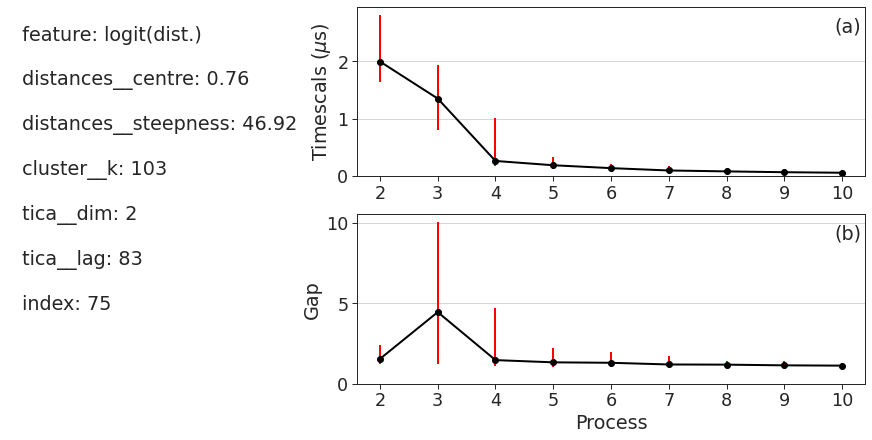

In [14]:
# Figure 2 : HP table + TS + TS gap

with sns.plotting_context('paper', font_scale=2):
    fig = plt.figure(figsize=(12, 6), constrained_layout=True)
    gs = fig.add_gridspec(nrows=6, ncols=12)
    
    # Hyperparameter values
    ax1 = fig.add_subplot(gs[:, :3])
    ax1.text(0.05, 0.95, str_to_print, transform=ax1.transAxes, verticalalignment='top')
    
    ax1.axis('off')

    
    # Timescales
    ax2 = fig.add_subplot(gs[:3, 3:])
    x = np.arange(n_ts-1)+2
    y = ts_median
    yerr = (ts_median-ts_lb, ts_ub-ts_median)
    ax2.errorbar(x, y, yerr, elinewidth=2, lw=2, marker='o', markersize=6, ecolor='r', c='k')
    
    ax2.set_ylabel(r"Timescals ($\mu$s)")
    ax2.tick_params(bottom=True, top=False, left=True, right=False)
    ax2.annotate(text='(a)', xy=(0.94, 0.94), xycoords='axes fraction', ha='left', va='top')
    ax2.grid(visible=True, axis='y')
    ax2.set_ylim([0, max(ts_ub)*1.05])
    
    # Gaps
    ax3 = fig.add_subplot(gs[3:, 3:])
    y = gap_median
    yerr = (gap_median-gap_lb, gap_ub-gap_median)
    ax3.errorbar(x, y, yerr, elinewidth=2, lw=2, marker='o', markersize=6, ecolor='r', c='k')
    
    ax3.set_ylabel("Gap")
    ax3.set_xlabel('Process')
    ax3.tick_params(bottom=True, top=False, left=True, right=False)
    ax3.annotate(text='(b)', xy=(0.94, 0.94), xycoords='axes fraction', ha='left', va='top')
    ax3.grid(visible=True, axis='y')
    ax3.set_ylim([0, max(gap_ub)*1.05])
    
    plt.savefig(fig_dir.joinpath('SI_fig2.png'), bbox_inches='tight')
    plt.show()

---
### Validate single MSM --- Figure 1

In [15]:
# Validate a single trial

ftrajs = ftrajs_all
assert len(ftrajs) == len(ftrajs_all)

ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)

out_dir = Path.joinpath(base_dir, Path(f'dtrajs'))
out_dir.mkdir(parents=True, exist_ok=True)

for j in range(len(traj_paths)): 
    traj_path = Path(traj_paths[j]).resolve()
    np.save(file=out_dir.joinpath(traj_path.with_suffix('.npy').name), arr=dtrajs[j])
        
msm = pm.msm.estimate_markov_model(dtrajs, lag=lag)
_ = msm.pcca(n_sets)
ts = msm.timescales(n_ts)

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████████| 164/164 [00:00<00:00, 508.72it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/103 [00:00<?, ?
initialize kmeans++ centers:  96%|▉| 99/103 [00:01<00:
kmeans iterations:   0%| | 1/1000 [00:01<22:00,  1.32s
kmeans iterations:   0%| | 2/1000 [00:01<11:04,  1.50i
kmeans iterations:   0%| | 3/1000 [00:01<07:32,  2.20i

In [16]:
# Compute PCCA population
# Population may need to be reweighted ?

print('\nstate\tπ\t\tG/kT\t\tNo.')
population = []
number = []
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    population.append(p)
    number.append(s.shape[0])
    print('{}\t{:f}\t{:f}\t{}'.format(i, p, -np.log(p), s.shape[0]))


state	π		G/kT		No.
0	0.020813	3.872174	12
1	0.703376	0.351864	69
2	0.275811	1.288040	22


In [17]:
# Compute core set 

ix_ls = []
core_memberships = msm.metastable_memberships.T > core_membership_cutoff
for i in range(len(core_memberships)):
    ix_ls.append(np.where(core_memberships[i])[0])
core_sets = np.array(ix_ls)

# Compute MFPT between core sets

mfpt = np.zeros((n_sets, n_sets))
for i, j in product(range(n_sets), repeat=2):
    mfpt[i, j] = msm.mfpt(core_sets[i], core_sets[j])

mfpt_df = pd.DataFrame(np.round(mfpt, decimals=2), index=range(1, n_sets + 1), columns=range(1, n_sets + 1))
print(mfpt_df, '\n(ns)')

           1        2        3
1       0.00  1023.31  9301.55
2   98901.89     0.00  8340.45
3  101710.23  2848.63     0.00 
(ns)


/tmp/ipykernel_2476021/564053929.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  core_sets = np.array(ix_ls)


In [25]:
# Map reference conformation
# Not used

ref_path = [r'../../../1fme/1fme.pdb' ]
    # r'../../../chignolin/5AWL_H.pdb'
test_labels = '1FME'
    # 5AWL

ftraj_test = featurizer(hps.loc[hp_ix, :].to_dict(), ref_path, top_path)
ftraj_test_tica = tica_mod.transform(ftraj_test)
microstate = kmeans_mod.assign(ftraj_test_tica)
metastate = msm.metastable_assignments[microstate]
#test_dict = {label:[test_traj_path[i], microstate[i][0], metastate[i][0]] for i, label in enumerate(test_labels)}

In [19]:
mem = msm.metastable_memberships.transpose()

# Microstate positions
x = kmeans_mod.clustercenters[:, 0]
y = kmeans_mod.clustercenters[:, 1]  

# Concatenate featurised trajectories
Y = np.concatenate(ttrajs)

# Find cluster center
dists = msm.metastable_distributions.copy()
dists[msm.metastable_memberships.T<core_membership_cutoff] = 0
dists = dists/np.sum(dists, axis=1)[:, np.newaxis]
max_dists = dists.copy()
mask = max_dists==np.tile(np.max(max_dists, axis=1)[:, np.newaxis], (max_dists.shape[1]))
max_ix = np.where(mask)[1]

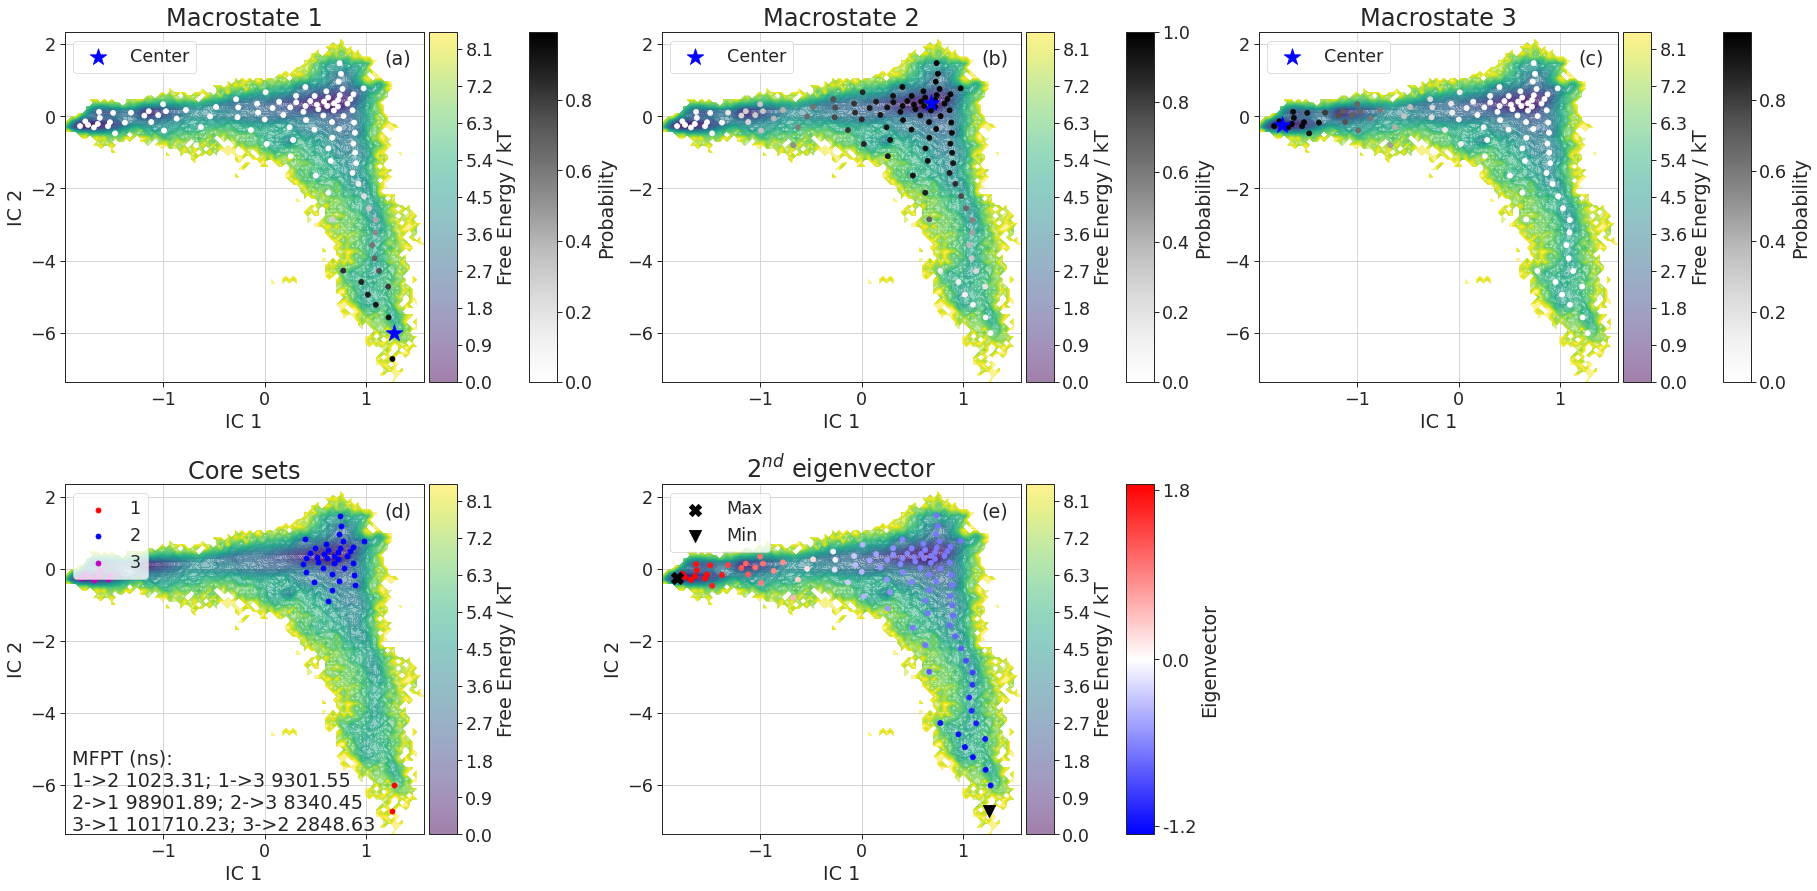

In [29]:
# Figure 1
pccas = []
pcca_cbs = []
fes_cbs = []

with sns.plotting_context('paper', font_scale=2):
    fig = plt.figure(figsize=(32, 32))
    gs = fig.add_gridspec(nrows=54, ncols=54)
    
    # Axes assignment 
    pccas.extend([fig.add_subplot(gs[:11, :11]), fig.add_subplot(gs[:11, 18:29])])
    mfpt = fig.add_subplot(gs[14:25, :11])   
    ev = fig.add_subplot(gs[14:25, 18:29])
    
    fes_cbs.extend([fig.add_subplot(gs[:11, 11]), fig.add_subplot(gs[:11, 29]),
                    fig.add_subplot(gs[14:25, 11]), fig.add_subplot(gs[14:25, 29])])
    pcca_cbs.extend([fig.add_subplot(gs[:11, 14]), fig.add_subplot(gs[:11, 32])])
    ev_cb = fig.add_subplot(gs[14:25, 32])
    
    if n_sets == 3: 
        pccas.append(fig.add_subplot(gs[:11, 36:47]))
        pcca_cbs.append(fig.add_subplot(gs[:11, 50]))
        fes_cbs.insert(2, fig.add_subplot(gs[:11, 47]))
    
        
    # Plot metastable membership
    for i_set, ax in enumerate(pccas):
        _, _ = pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], cmap='viridis', 
                                    alpha=0.5, 
                                    weights=np.concatenate(msm.trajectory_weights()),
                                    cbar_label='Free Energy / kT', 
                                    ax=ax, cax=fes_cbs[i_set])
        
        # Microstates
        ms = pccas[i_set].scatter(x=x, y=y, c=mem[i_set], cmap='Greys', s=25, 
                       vmin=mem[i_set].min(), vmax=mem[i_set].max())
        cbar = plt.colorbar(ms, cax=pcca_cbs[i_set])
        cbar.ax.set_ylabel('Probability')
        
        # Macrostate centers 
        pccas[i_set].scatter(x=x[max_ix[i_set]],y=y[max_ix[i_set]], color='b', marker='*',
                             s=300, label='Center')
        
  
    # Plot core set assignment & MFPT
    _, _ = pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], cmap='viridis', 
                                alpha=0.5, 
                                weights=np.concatenate(msm.trajectory_weights()),
                                cbar_label='Free Energy / kT', 
                                ax=mfpt, cax=fes_cbs[i_set+1])
    for i_set in range(n_sets):
        ms = mfpt.scatter(x=x[core_sets[i_set]], y=y[core_sets[i_set]], c=['r','b','m'][i_set],
                          label=f'{i_set+1}', s=25)
        
    txt = 'MFPT (ns):\n'    
    if n_sets == 2:
        txt += f'1->2 {mfpt_df.iloc[0,1]}\n2->1 {mfpt_df.iloc[1,0]}'
    else:
        txt += f'1->2 {mfpt_df.iloc[0,1]}; 1->3 {mfpt_df.iloc[0,2]}\n2->1 {mfpt_df.iloc[1,0]}; 2->3 {mfpt_df.iloc[1,2]}\n3->1 {mfpt_df.iloc[2,0]}; 3->2 {mfpt_df.iloc[2,1]} '
    
    
    # Plot 2nd eigenvector 
    _, _ = pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], cmap='viridis', 
                                alpha=0.5, 
                                weights=np.concatenate(msm.trajectory_weights()),
                                cbar_label='Free Energy / kT', 
                                ax=ev, cax=fes_cbs[i_set+2])
    
    vmin = np.min(msm.eigenvectors_right()[:, 1]) 
    vmax = np.max(msm.eigenvectors_right()[:, 1]) 
    divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
    egv_max = msm.eigenvectors_right()[:, 1].argmax()
    egv_min = msm.eigenvectors_right()[:, 1].argmin()
    
    ms = ev.scatter(x=x, y=y, c=msm.eigenvectors_right()[:, 1], cmap='bwr', norm=divnorm, s=25)    
    ev.scatter(x=x[egv_max], y=y[egv_max], c='k', 
                  cmap='bwr', norm=divnorm, marker='X', s=150, alpha=1, label='Max')
    ev.scatter(x=x[egv_min], y=y[egv_min], c='k', 
                  cmap='bwr', norm=divnorm, marker='v', s=150, alpha=1, label='Min')
    cbar = plt.colorbar(ms, cax=ev_cb, ticks=[np.ceil(vmin*10)/10, 0, np.floor(vmax*10)/10])
    cbar.ax.set_yticklabels([np.ceil(vmin*10)/10, 0.0, np.floor(vmax*10)/10])
    cbar.ax.set_ylabel('Eigenvector')
    
    # Configurations
    for i_set, ax in enumerate(pccas):
        ax.tick_params(bottom=True, top=False, left=True, right=False)
        ax.grid(visible=True, axis='both')
        ax.legend(loc='upper left')
        ax.set_xlabel('IC 1')
        ax.set_title(f'Macrostate {i_set+1}', fontsize=24)
    pccas[0].set_ylabel('IC 2')
    for ax in fes_cbs:
        ax.tick_params(bottom=False, top=False, left=False, right=True)
    for ax in pcca_cbs:
        ax.tick_params(bottom=False, top=False, left=False, right=True)
        
    mfpt.set_xlabel('IC 1')
    mfpt.set_ylabel('IC 2')
    mfpt.legend(loc='upper left')
    mfpt.annotate(text=txt, xy=(0.02, 0), xycoords='axes fraction', ha='left', va='bottom')
    mfpt.grid(visible=True, axis='both')
    mfpt.tick_params(bottom=True, top=False, left=True, right=False)
    mfpt.set_title('Core sets', fontsize=24)
    
    ev.legend(loc='upper left')
    ev.grid(visible=True, axis='both')
    ev.set_xlabel('IC 1')
    ev.set_ylabel('IC 2')
    ev.tick_params(bottom=True, top=False, left=True, right=False)
    ev.set_title('$2^{nd}$ eigenvector', fontsize=24)
    
    for i, ax in enumerate(pccas+[mfpt, ev]):
        ax.annotate(text=f'({string.ascii_lowercase[i]})', xy=(0.89, 0.95), xycoords='axes fraction', ha='left', va='top')
        
    
    plt.savefig(fig_dir.joinpath('SI_fig1.png'))
    plt.show()

---
### Sample egv2 extreme states

In [26]:
is_single_core = True
ref = md.load(ref_path)
state_out_dir = base_dir.joinpath('states')
state_out_dir.mkdir(exist_ok=True, parents=True)

In [27]:
samples = {}
for i in range(2):
    egv_max = msm.eigenvectors_right()[:, i+1].argmax()
    egv_min = msm.eigenvectors_right()[:, i+1].argmin()
    egv_zero = abs(msm.eigenvectors_right()[:, i+1]).argmin()
    samples[f'egv{i+2}_max_{egv_max}'] = msm.sample_by_state(100, [egv_max])
    samples[f'egv{i+2}_min_{egv_min}'] = msm.sample_by_state(100, [egv_min])
    samples[f'egv{i+2}_zero_{egv_zero}'] = msm.sample_by_state(100, [egv_zero])

In [28]:
rmsds = []
states = []

with open(state_out_dir.joinpath('out.txt'), 'w') as f: 
    f.writelines(f'Protein {protein}; hp_id {hp_ix}\n')
    
    for n, sample in samples.items():
        outfile = str(state_out_dir.joinpath(f'{n}.pdb'))

        traj = pm.coordinates.save_traj(traj_paths, sample, outfile=None, top=top_path)
        traj.superpose(reference=ref)
        states.append(traj)
        traj.save_pdb(str(outfile))

        # Compute rg
        rg = md.compute_rg(traj)
        ave_rg, std_rg = np.mean(rg), np.std(rg)

        # Compute rmsd (nm) within samples
        rmsd_list = []
        for i in range(len(traj)):
            rmsd_list.append(md.rmsd(traj, traj[i]))
        rmsd_array = np.array(rmsd_list)*10
        ave_rmsd, std_rmsd = np.mean(rmsd_array), np.std(rmsd_array)
        
        rmsd = md.rmsd(target=traj, reference=ref)*10
        ave_ref_rmsd, std_ref_rmsd = np.mean(rmsd), np.std(rmsd)
        rmsds.append(rmsd)
        
        f.writelines(f'{n}\naverage_rg {ave_rg:.2f}, std_rg {std_rg:.2f}\naverage_rmsd {ave_rmsd:.2f}, std_rmsd {std_rmsd:.2f}\nave_ref_rmsd {ave_ref_rmsd:.2f}, std_ref_rmsd {std_ref_rmsd:.2f}\n\n')
    
rmsds_df = pd.DataFrame({f"state_{i}": np.round(rmsd,2) for i, rmsd in enumerate(rmsds)}).melt()

100%|████████████████| 46/46 [00:00<00:00, 358.42it/s]
